In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install scanpy

In [3]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib as mpl
import anndata as ad
import seaborn as sns
from collections import Counter
import scipy.io
import glob
import matplotlib.pyplot as plt
from pathlib import Path
import pylab

import os

import re
import gc


sc.settings.verbosity = 3 
sc.settings.set_figure_params(dpi=250) #INCREASE LATER!


pylab.rcParams['figure.figsize'] = (7, 4.5)

In [4]:
%cd /content/drive/MyDrive/MBA/
%ls

/content/drive/MyDrive/MBA
'Avaliação Final AM.docx'   Data/       Notebooks/         pancreas_ct1.gsheet
 cache/                     Diabetes/   pancreas_ct1.csv   pancreas.h5ad


# Loading Data

In [5]:
meta = pd.read_excel("./Diabetes/Meta.xlsx", header=2, index_col="Cell.ID")
print(meta.shape)
meta.head()

(39905, 4)


Tx.all   Tx.D Donor celltype
Cell.ID                                     
AAAAAAAATAGG       880  297.0    H1  allBeta
AAAAAAATAATT_e     580  381.0    H5     Beta
AAAAAACGTCCA_f     281  281.0    H6    Alpha
AAAAAAGTGAAA_d     147  147.0    H4      NaN
AAAAAATCAGAA_e     535  343.0    H5    Alpha

In [6]:
meta.celltype.unique()

array(['allBeta', 'Beta', 'Alpha', nan, 'duct', 'pp', 'psc', 'delta',
       'Acinar', 'Epsilon'], dtype=object)

In [7]:
meta = meta.loc[~meta.celltype.isna()]

In [8]:
ids = os.listdir("./Diabetes/GSE101207_RAW")
print(ids)
ids = [i for i in ids if i.endswith(".txt")]
print(ids)
print(len(ids))

['GSM2700339_H2.down.gene_exon_tagged.cleaned.dge.txt', 'GSM2700340_H3.down.gene_exon_tagged.cleaned.dge.txt', 'GSM2700341_H4.down.gene_exon_tagged.cleaned.dge.txt', 'GSM2700342_H5.down.gene_exon_tagged.cleaned.dge.txt', 'GSM2700343_T2D1.down.gene_exon_tagged.cleaned.dge.txt', 'GSM2700344_T2D2.down.gene_exon_tagged.cleaned.dge.txt', '._GSM2700338_H1.down.gene_exon_tagged.cleaned.dge.txt.gz', '._GSM2700339_H2.down.gene_exon_tagged.cleaned.dge.txt.gz', '._GSM2700340_H3.down.gene_exon_tagged.cleaned.dge.txt.gz', '._GSM2700341_H4.down.gene_exon_tagged.cleaned.dge.txt.gz', '._GSM2700342_H5.down.gene_exon_tagged.cleaned.dge.txt.gz', '._GSM2700343_T2D1.down.gene_exon_tagged.cleaned.dge.txt.gz', '._GSM2700344_T2D2.down.gene_exon_tagged.cleaned.dge.txt.gz', '._GSM2863188_H6.down.gene_exon_tagged.cleaned.dge.txt.gz', '._GSM2863189_T2D3.down.gene_exon_tagged.cleaned.dge.txt.gz', 'GSM2700338_H1.down.gene_exon_tagged.cleaned.dge.txt', '._.DS_Store', '.DS_Store', 'GSM2863188_H6.down.gene_exon_tagged

In [9]:
ids.sort()
print(ids)

['GSM2700338_H1.down.gene_exon_tagged.cleaned.dge.txt', 'GSM2700339_H2.down.gene_exon_tagged.cleaned.dge.txt', 'GSM2700340_H3.down.gene_exon_tagged.cleaned.dge.txt', 'GSM2700341_H4.down.gene_exon_tagged.cleaned.dge.txt', 'GSM2700342_H5.down.gene_exon_tagged.cleaned.dge.txt', 'GSM2700343_T2D1.down.gene_exon_tagged.cleaned.dge.txt', 'GSM2700344_T2D2.down.gene_exon_tagged.cleaned.dge.txt', 'GSM2863188_H6.down.gene_exon_tagged.cleaned.dge.txt', 'GSM2863189_T2D3.down.gene_exon_tagged.cleaned.dge.txt']


In [10]:
adatas = []
let = {"H1": "", "H2": "_b", "H3": "_c", "H4": "_d", "H5":"_e", "H6":"_f", "T2D1":"_g", "T2D2":"_h", "T2D3":"_i"}
for i in ids:
  donor = i.split(".")[0].split("_")[1]
  x = pd.read_csv("./Diabetes/GSE101207_RAW/"+i, sep="\t", index_col="GENE").T
  gc.collect()
  x.index = [j + let[donor] for j in x.index]
  print(x.shape)
  x = x.loc[x.index.isin(meta.index)]
  gc.collect()
  print(x.shape)
  print(x.head())
  adatas.append(ad.AnnData(X=x, obs=pd.DataFrame({"Donor": [donor for i in x.index]}, index=x.index)))
adatas

(4000, 15764)
(809, 15764)
GENE          A1BG  A1BG-AS1  A1CF  A2M  ...  ZYG11B  ZYX  ZZEF1  ZZZ3
CCTCGCAACGTC     0         0     2    0  ...       0    0      0     1
GGCGTAAGATGG     0         0     0    0  ...       0    0      0     0
CGATACTTAAAG     0         0     0    0  ...       0    0      0     0
ACCCCCAGGCGA     1         0     2    0  ...       0    1      0     1
GCGCATCGGTCA     3         0     0    0  ...       1    1      0     0

[5 rows x 15764 columns]
(4000, 15045)
(731, 15045)
GENE            A1BG  A1BG-AS1  A1CF  A2M  ...  ZYG11B  ZYX  ZZEF1  ZZZ3
ACTGTCAGATGT_b     0         0     1    0  ...       1    0      1     0
AGCGATGGTTGA_b     1         0     3    0  ...       0    0      1     0
GCAAGTTGTGTC_b     2         0     1    0  ...       0    0      0     3
CCAACCACTACG_b     1         0     0    0  ...       0    0      0     0
TGGTGGACATAT_b     1         0     1    0  ...       0    1      0     0

[5 rows x 15045 columns]
(20000, 18098)
(6465, 18098)
G

[AnnData object with n_obs × n_vars = 809 × 15764
     obs: 'Donor', AnnData object with n_obs × n_vars = 731 × 15045
     obs: 'Donor', AnnData object with n_obs × n_vars = 6465 × 18098
     obs: 'Donor', AnnData object with n_obs × n_vars = 4930 × 17629
     obs: 'Donor', AnnData object with n_obs × n_vars = 3632 × 17278
     obs: 'Donor', AnnData object with n_obs × n_vars = 864 × 15219
     obs: 'Donor', AnnData object with n_obs × n_vars = 1254 × 15697
     obs: 'Donor', AnnData object with n_obs × n_vars = 5352 × 17436
     obs: 'Donor', AnnData object with n_obs × n_vars = 3959 × 17132
     obs: 'Donor']

In [11]:
adata = ad.concat(adatas)

In [12]:
meta.columns

Index(['Tx.all', 'Tx.D', 'Donor', 'celltype'], dtype='object')

In [13]:
meta = meta.loc[meta.index.isin(adata.obs.index), ["Donor", "celltype"]]
meta = meta.reindex(index=adata.obs.index)
meta.head()

Donor celltype
CCTCGCAACGTC    H1    Alpha
GGCGTAAGATGG    H1    Alpha
CGATACTTAAAG    H1     Beta
ACCCCCAGGCGA    H1    delta
GCGCATCGGTCA    H1       pp

In [14]:
adata.obs["Celltype"] = meta.celltype
adata

AnnData object with n_obs × n_vars = 27996 × 13102
    obs: 'Donor', 'Celltype'

In [15]:
adata.write("pancreas_raw.h5ad")

... storing 'Donor' as categorical
... storing 'Celltype' as categorical


### Pré-tratamento

normalizing counts per cell
    finished (0:00:01)


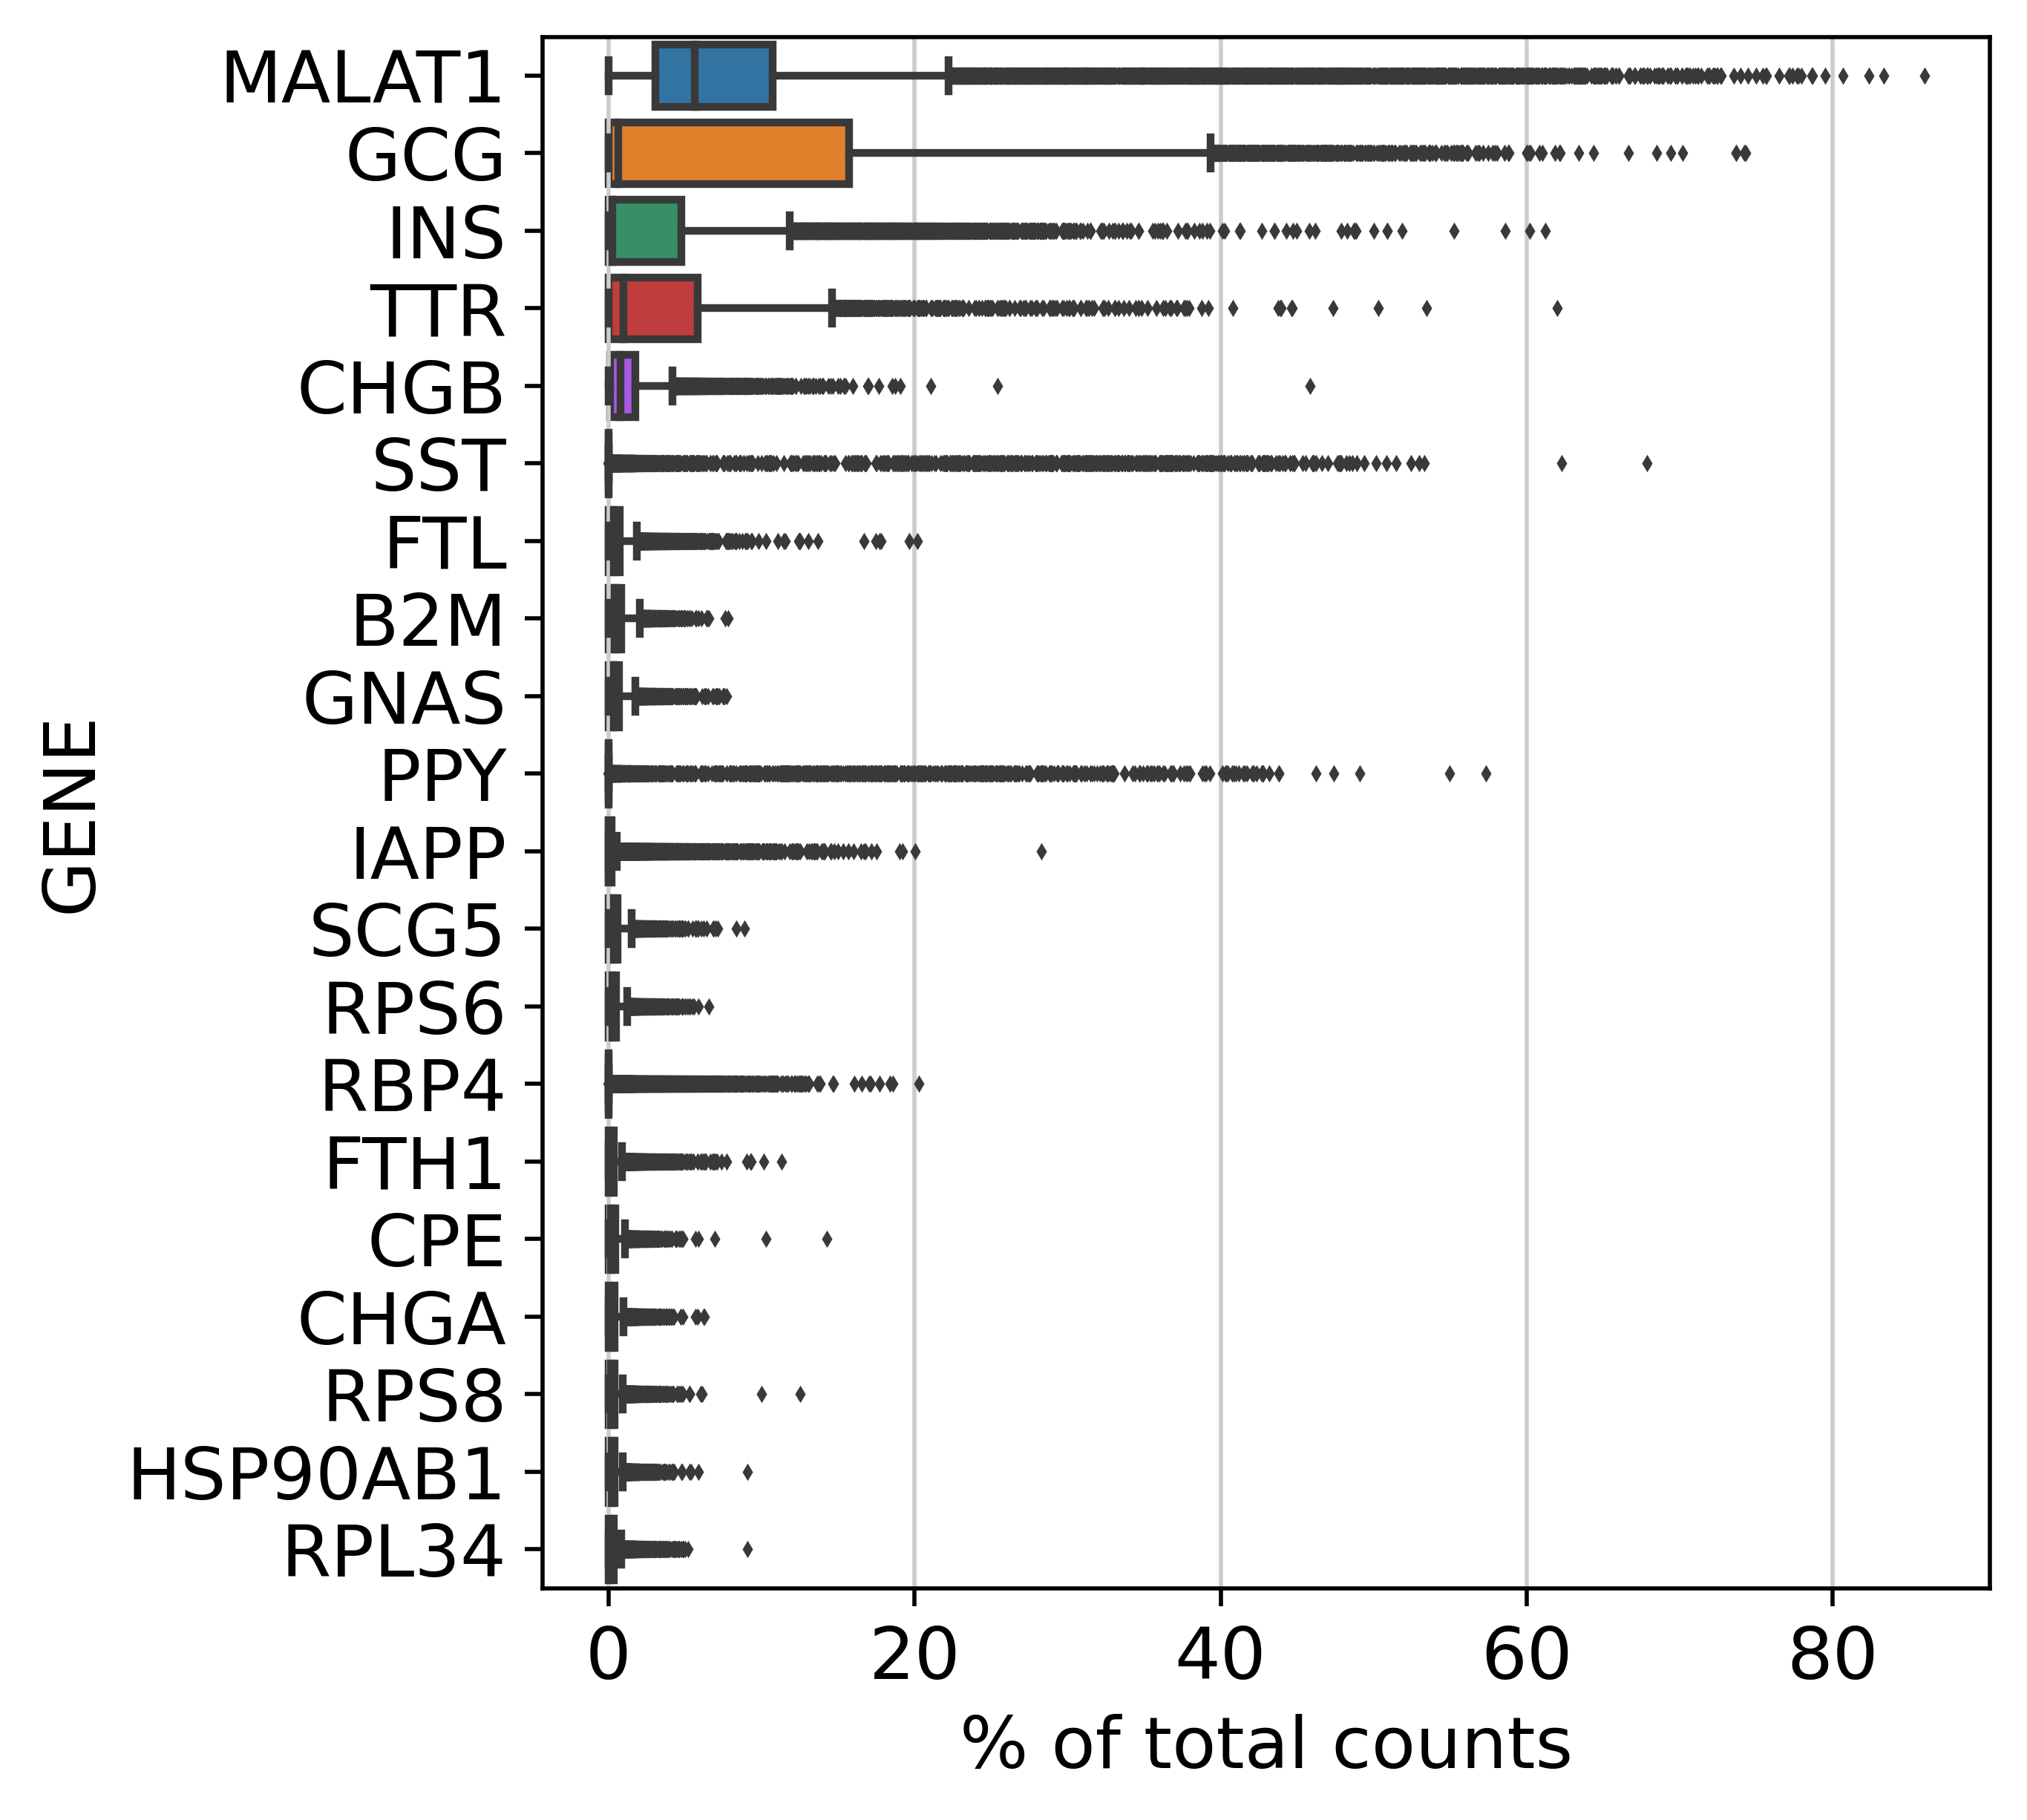

In [16]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [17]:
sc.pp.filter_cells(adata, min_genes=50)

filtered out 1770 cells that have less than 50 genes expressed


In [18]:
adata.var['mt'] = adata.var_names.str.startswith('MT')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

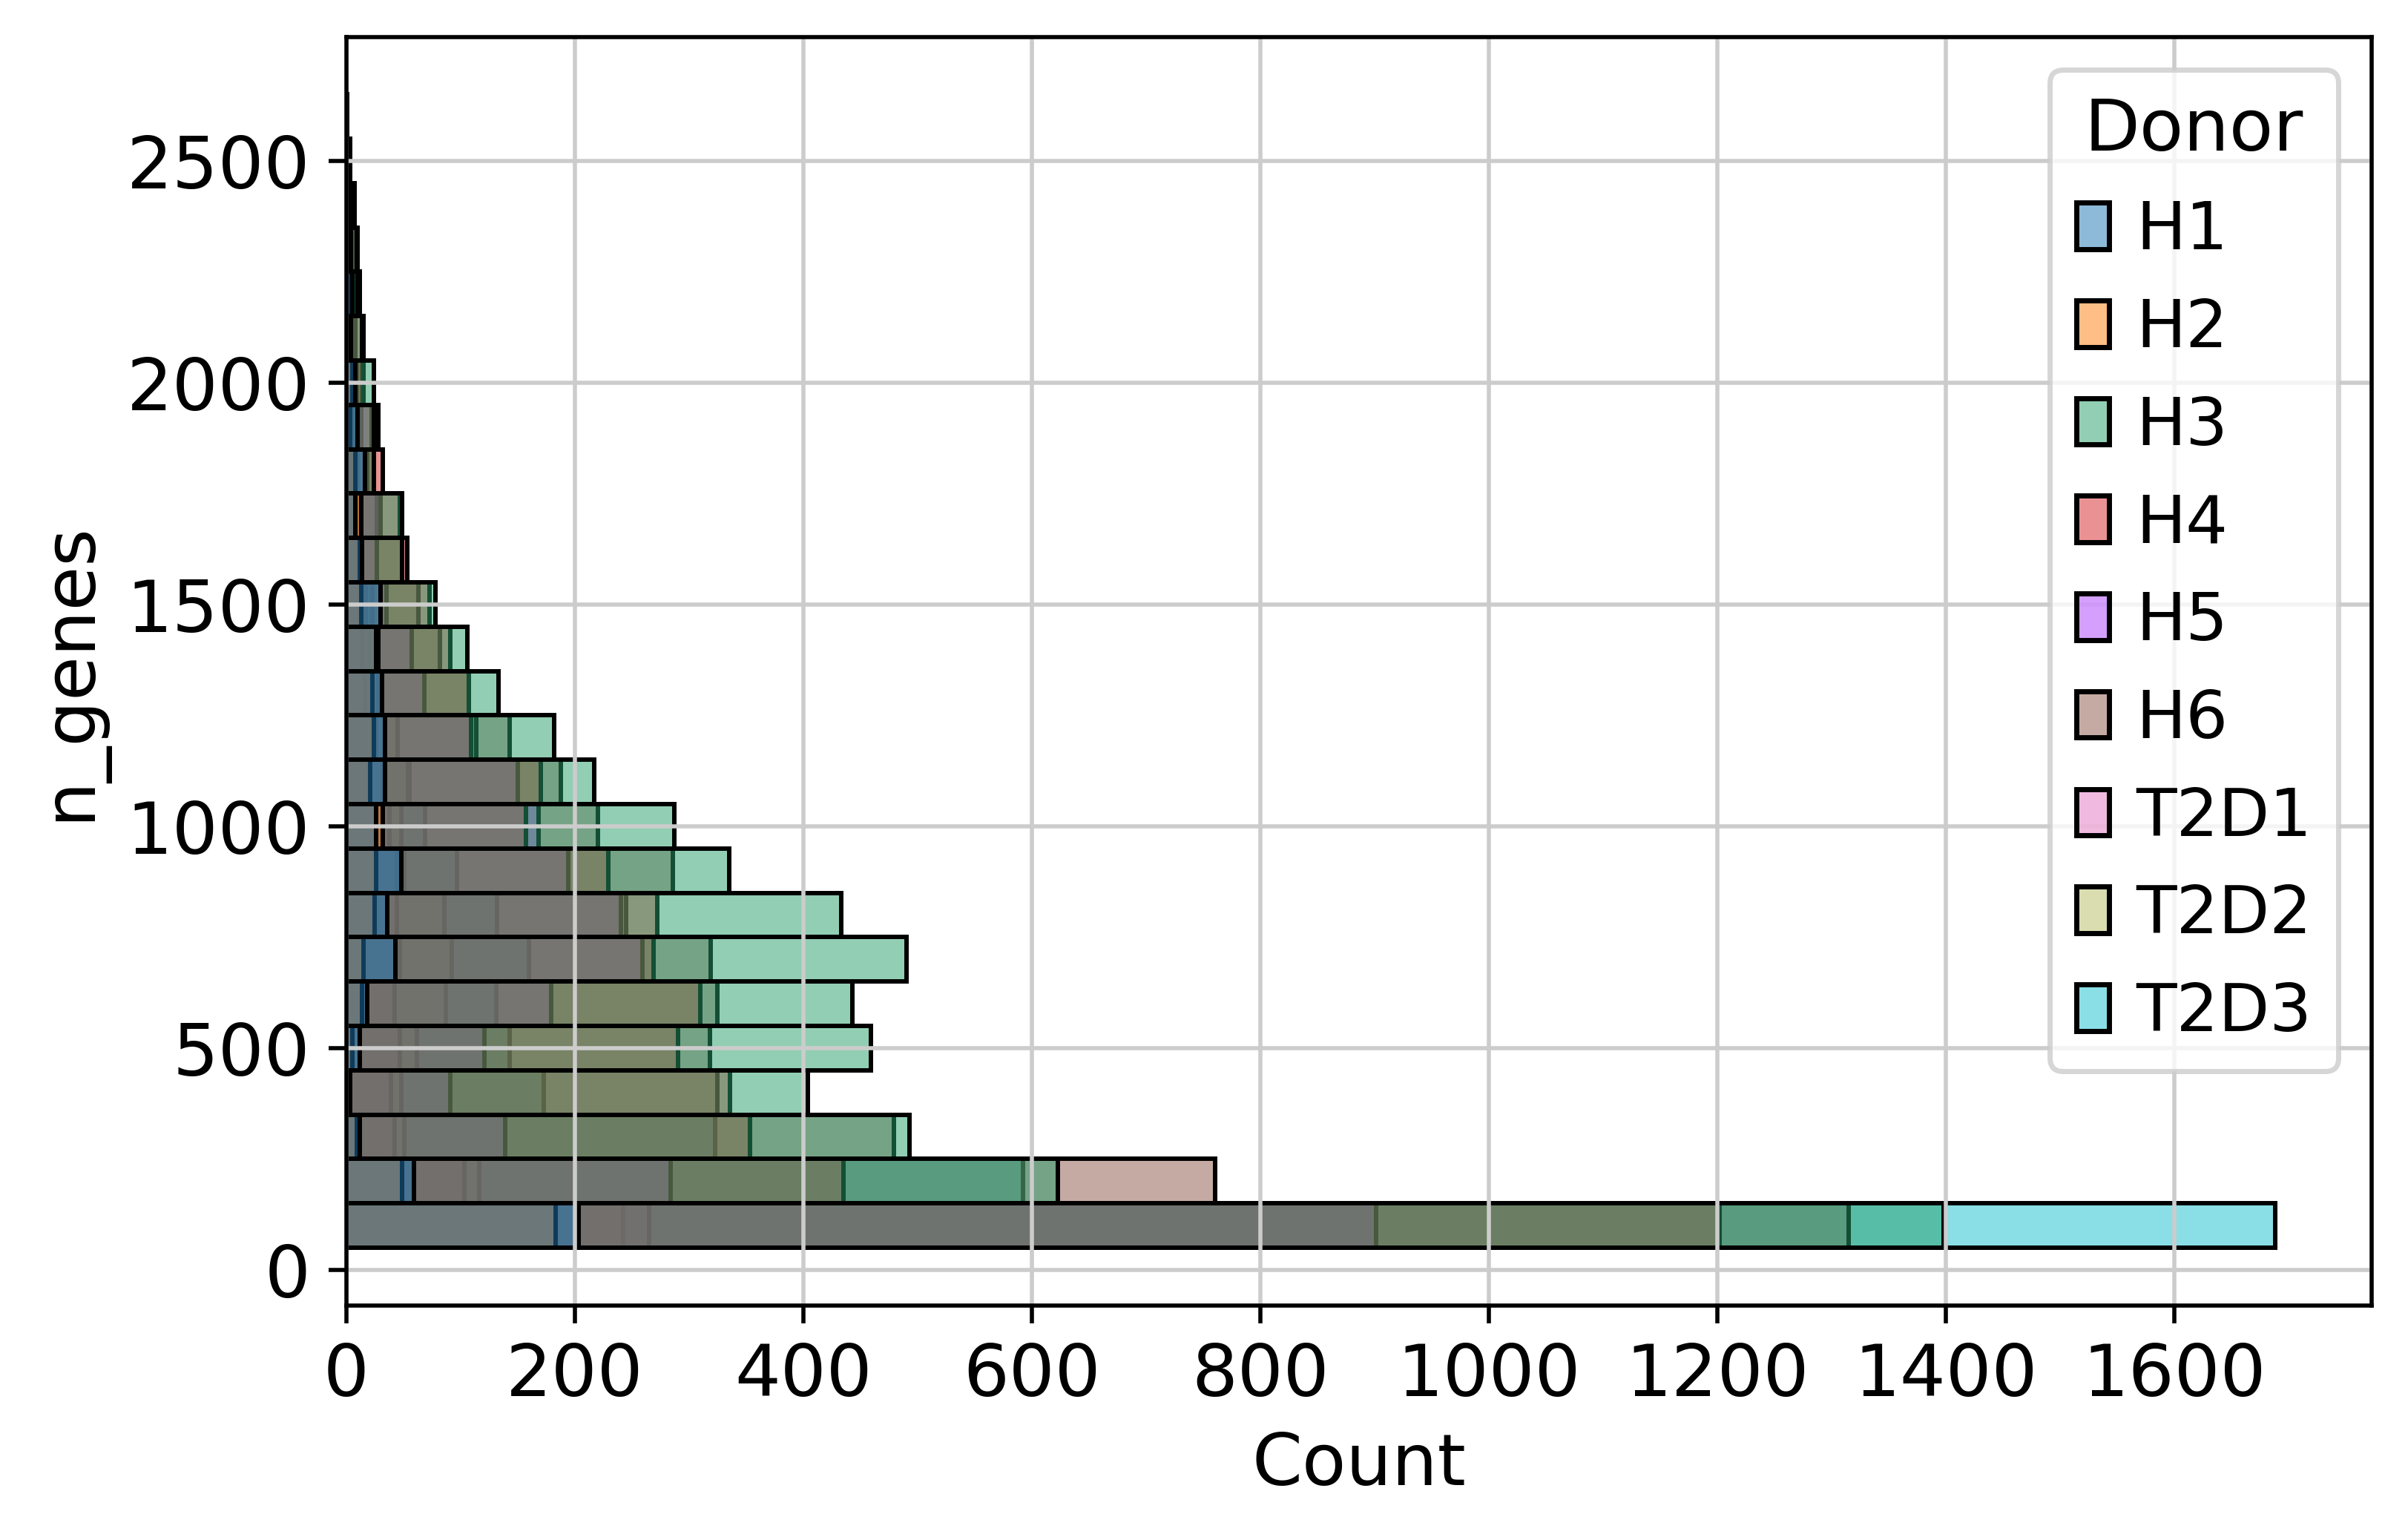

In [19]:
sns.histplot(y = "n_genes", hue="Donor", data=adata.obs.sort_values(by="Donor"), binwidth=100)

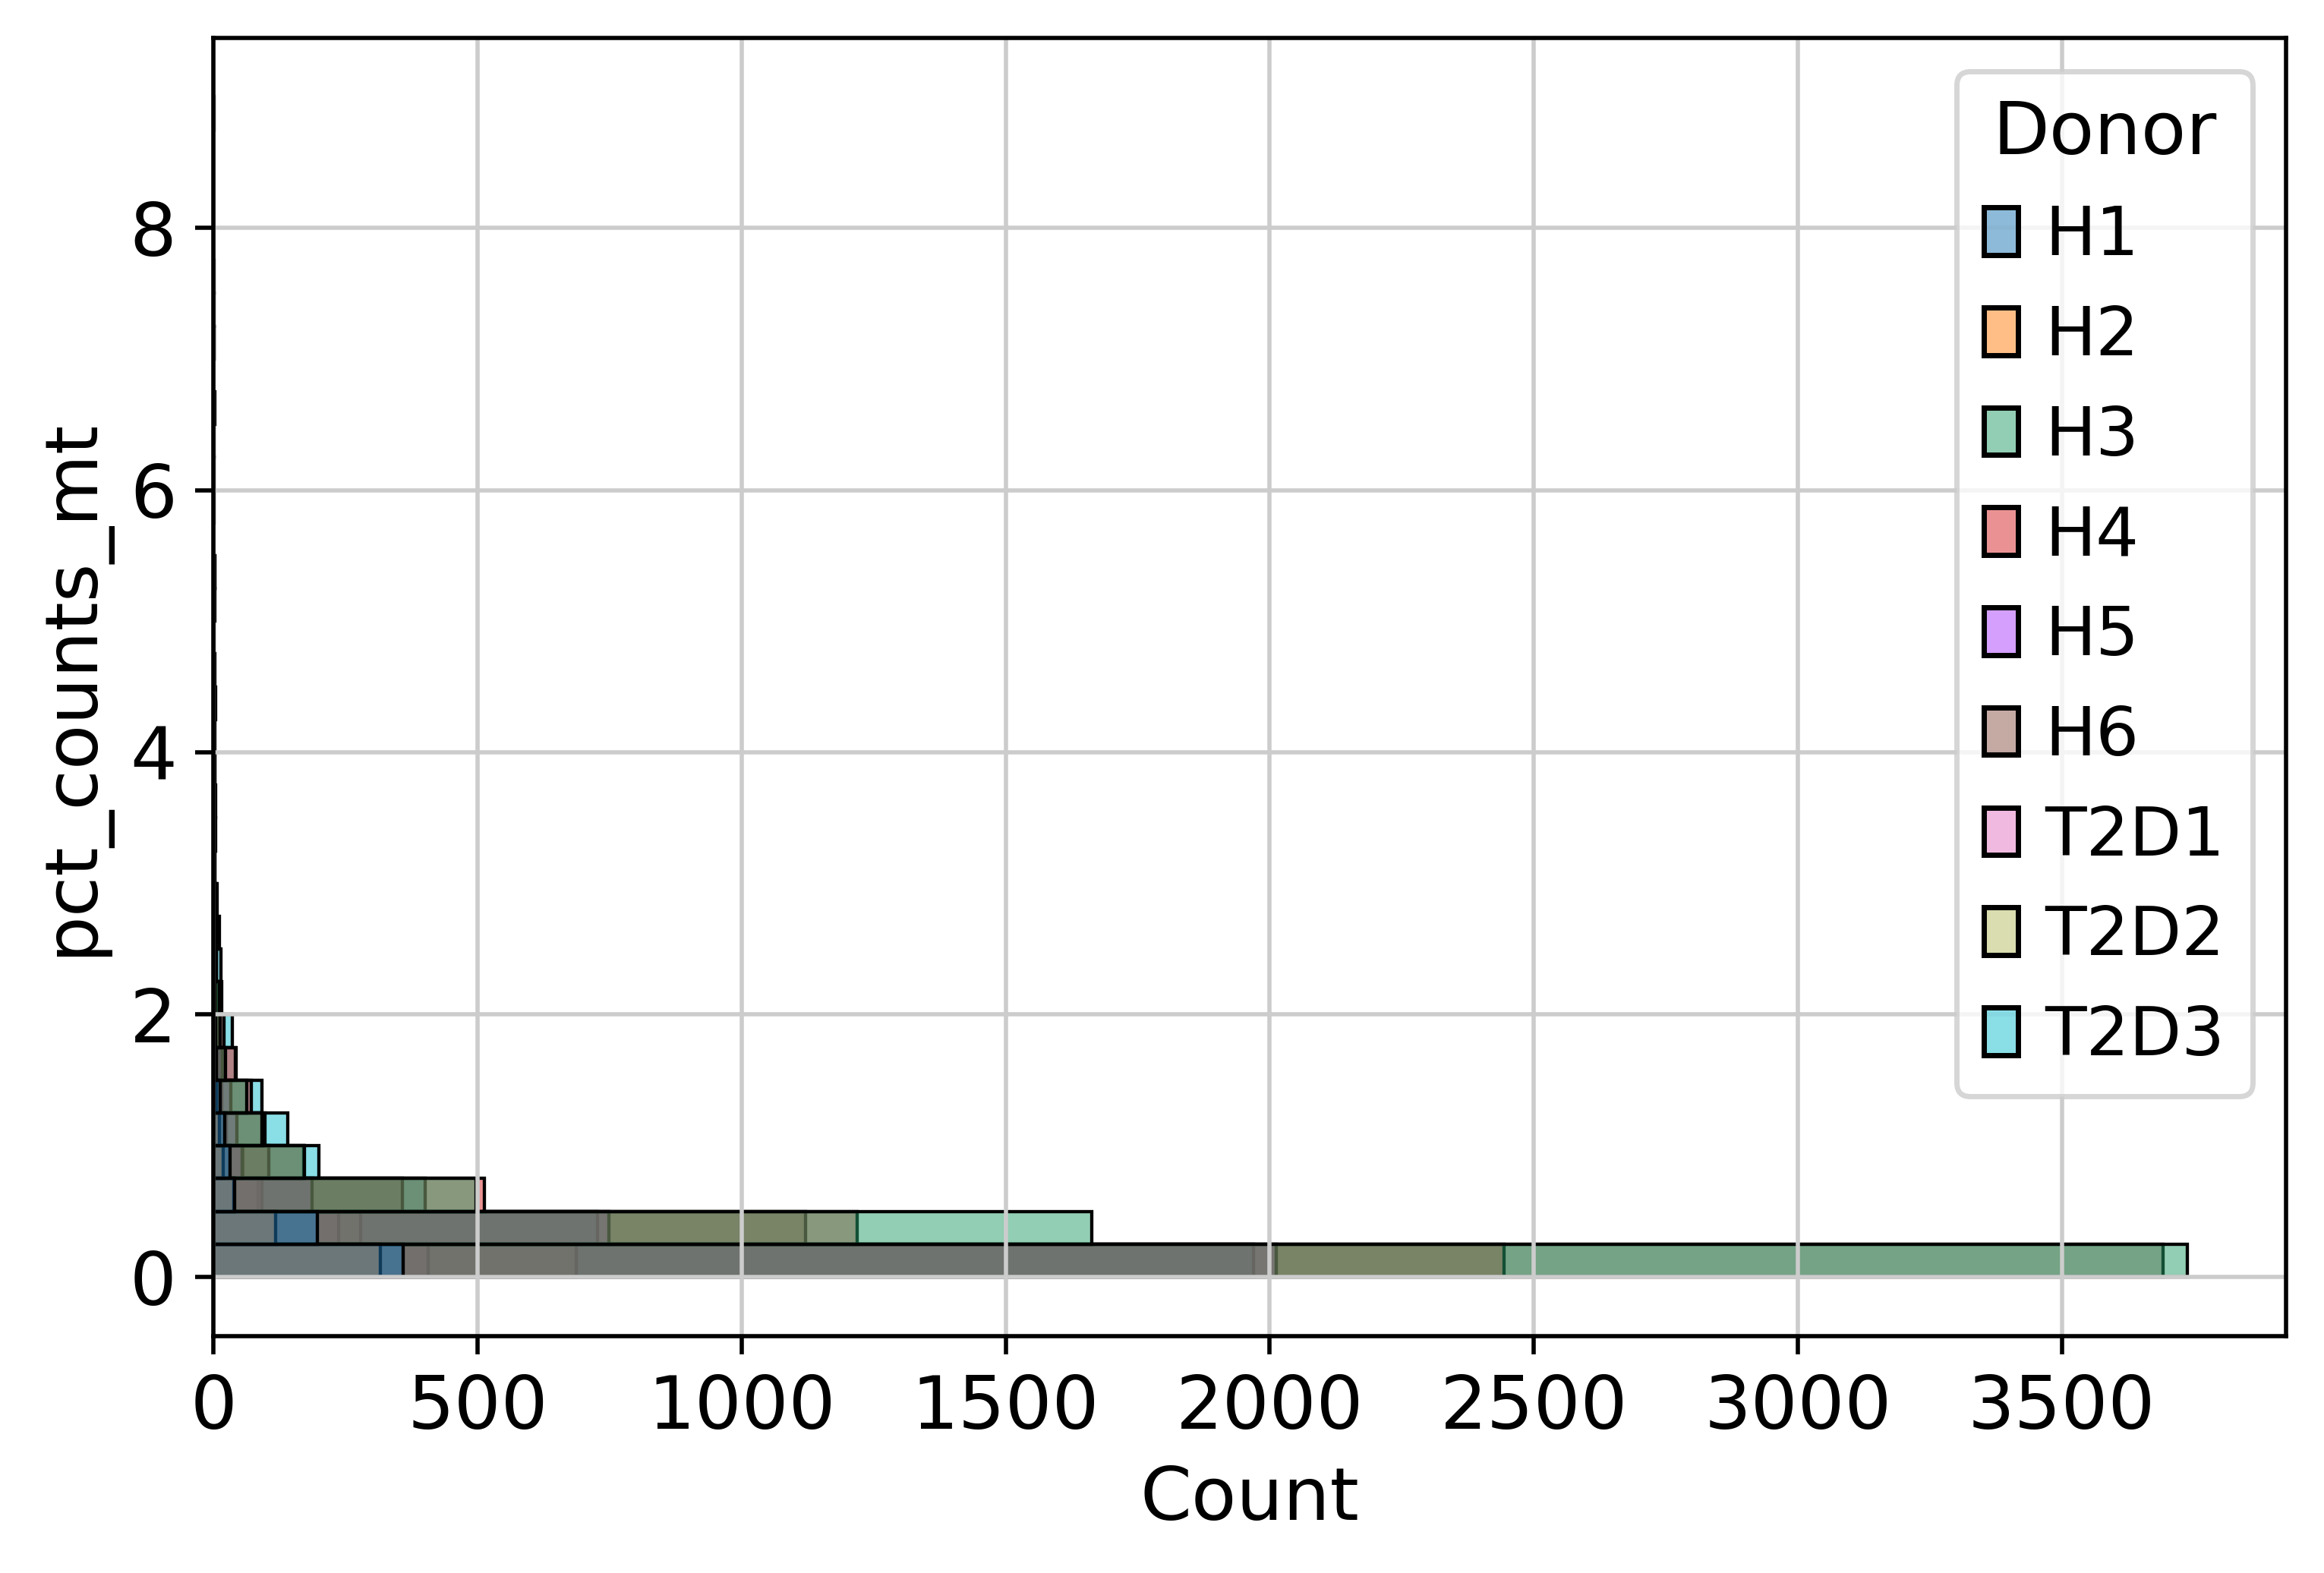

In [20]:
sns.histplot(y = "pct_counts_mt", hue="Donor", data=adata.obs.sort_values(by="Donor"), binwidth=0.25)

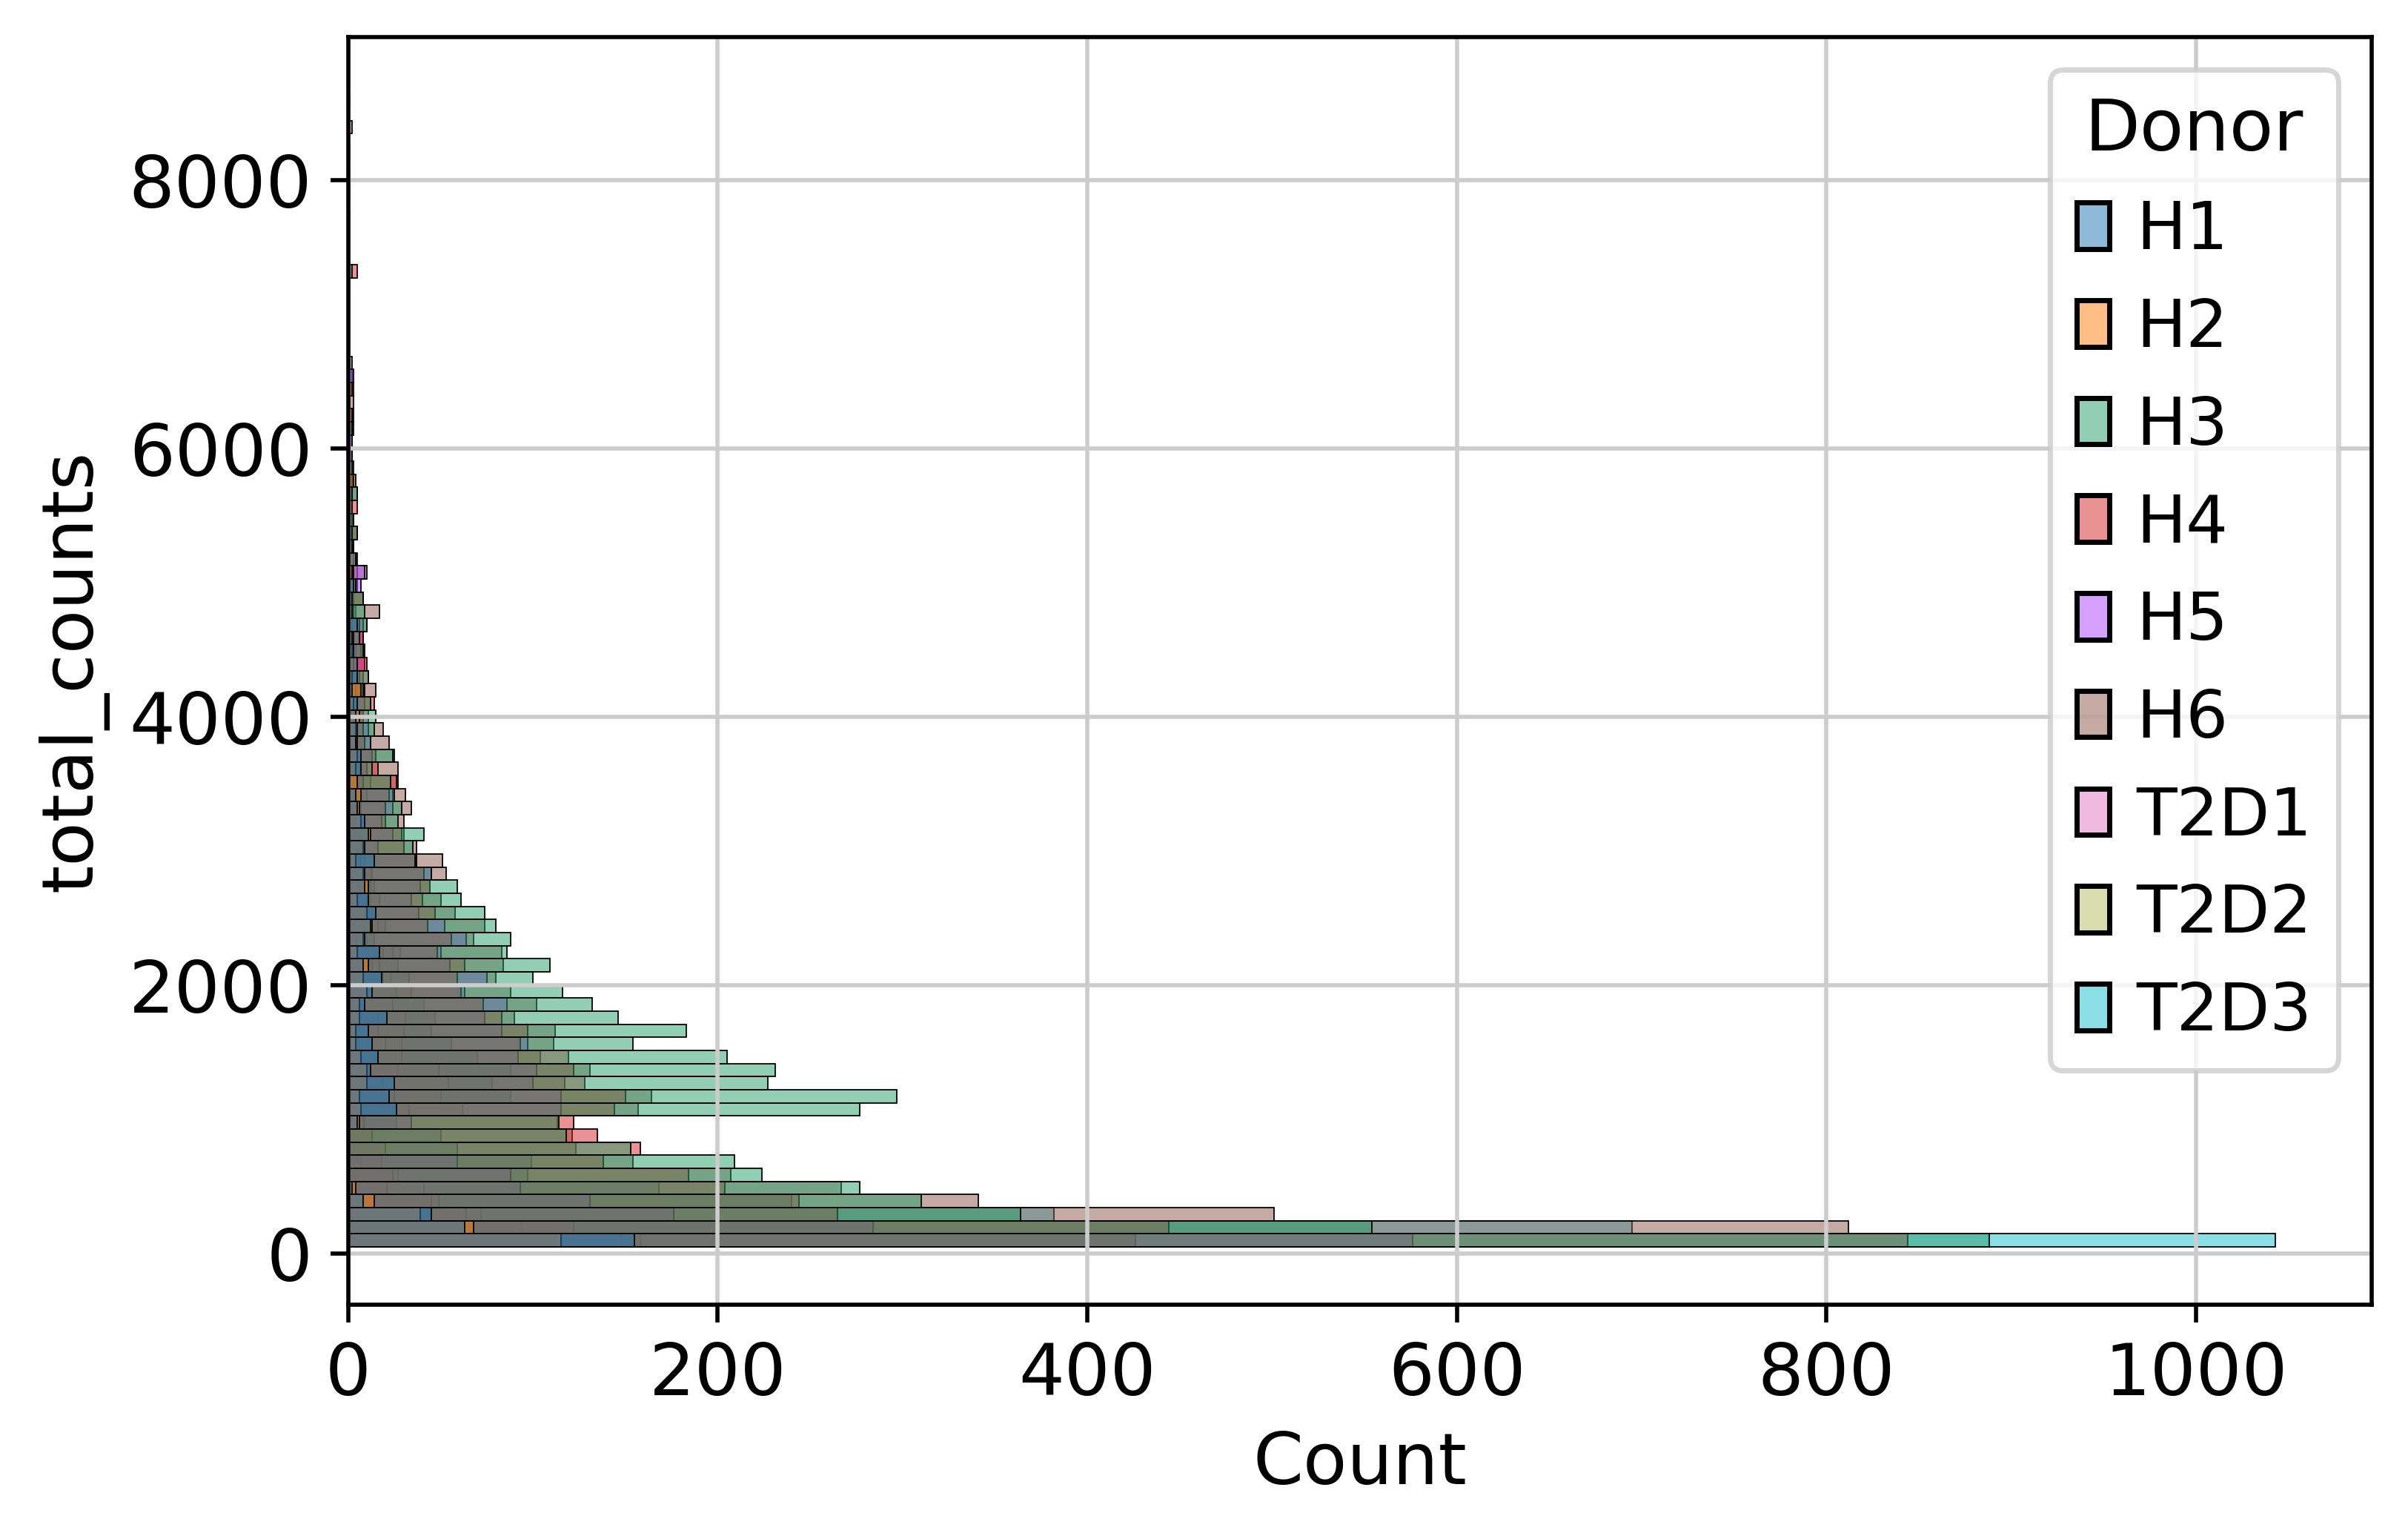

In [21]:
sns.histplot(y = "total_counts", hue="Donor", data=adata.obs.sort_values(by="Donor"))

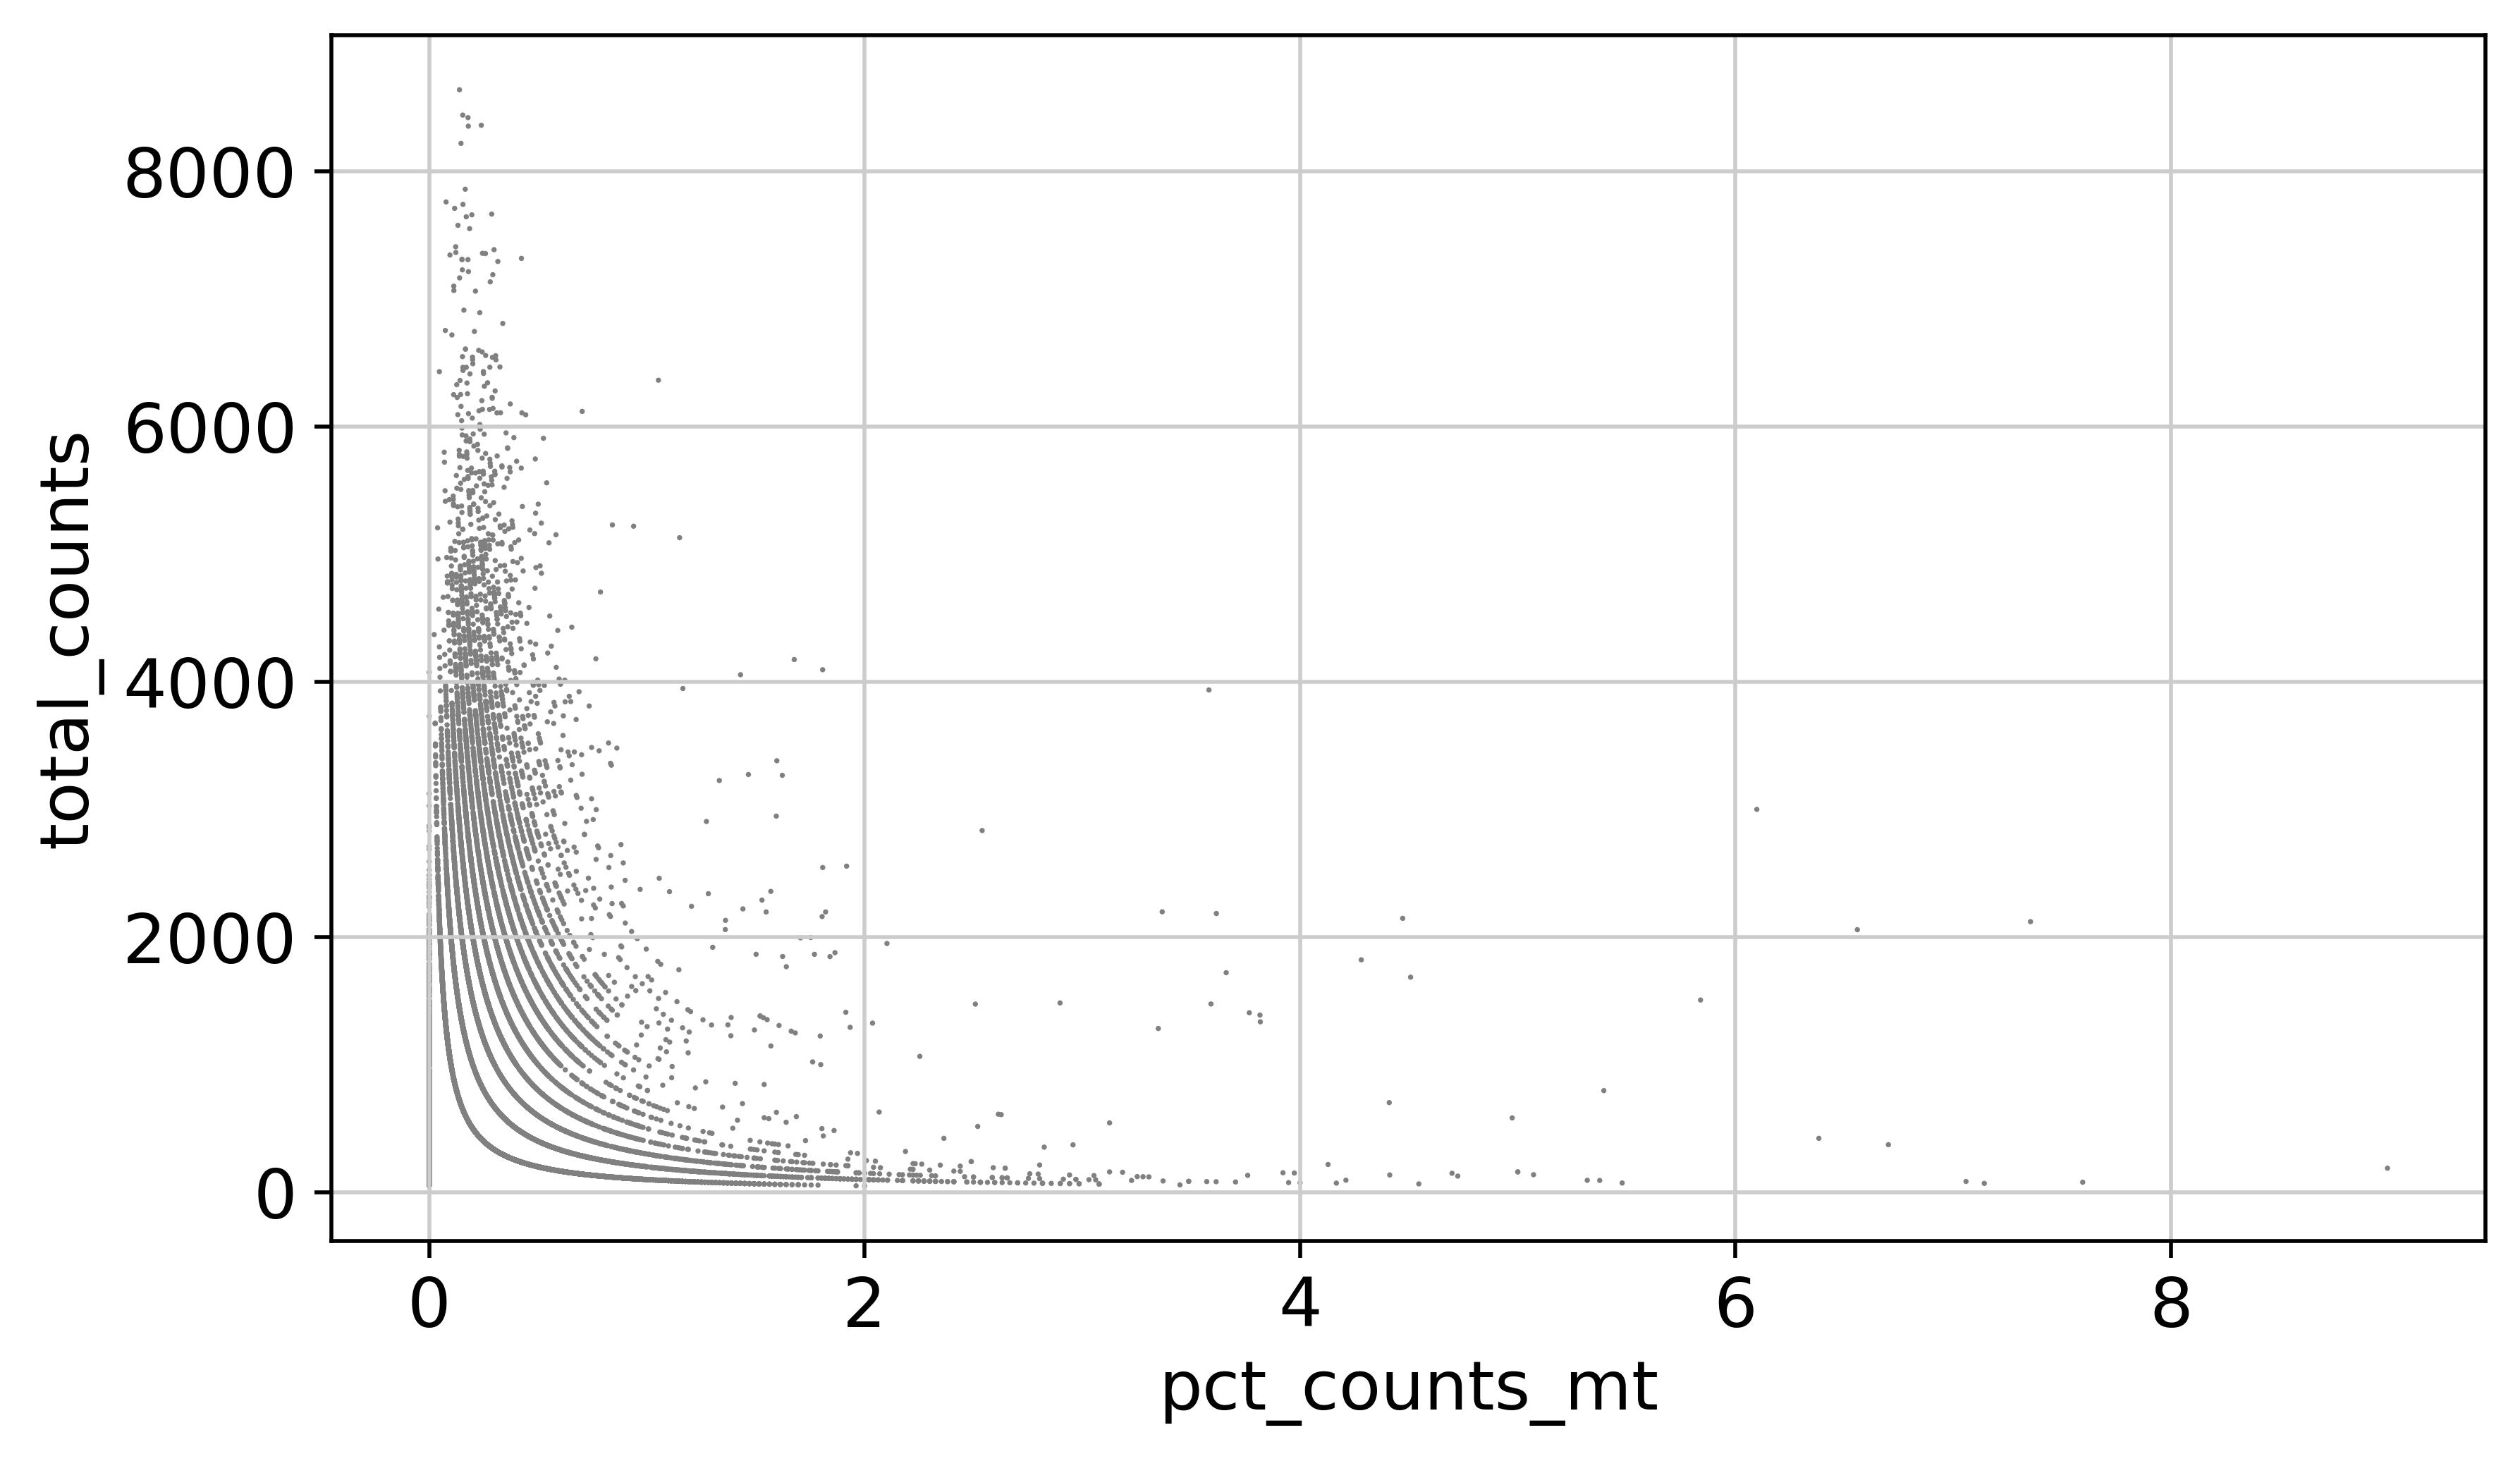

In [22]:
sc.pl.scatter(adata, x='pct_counts_mt', y='total_counts')

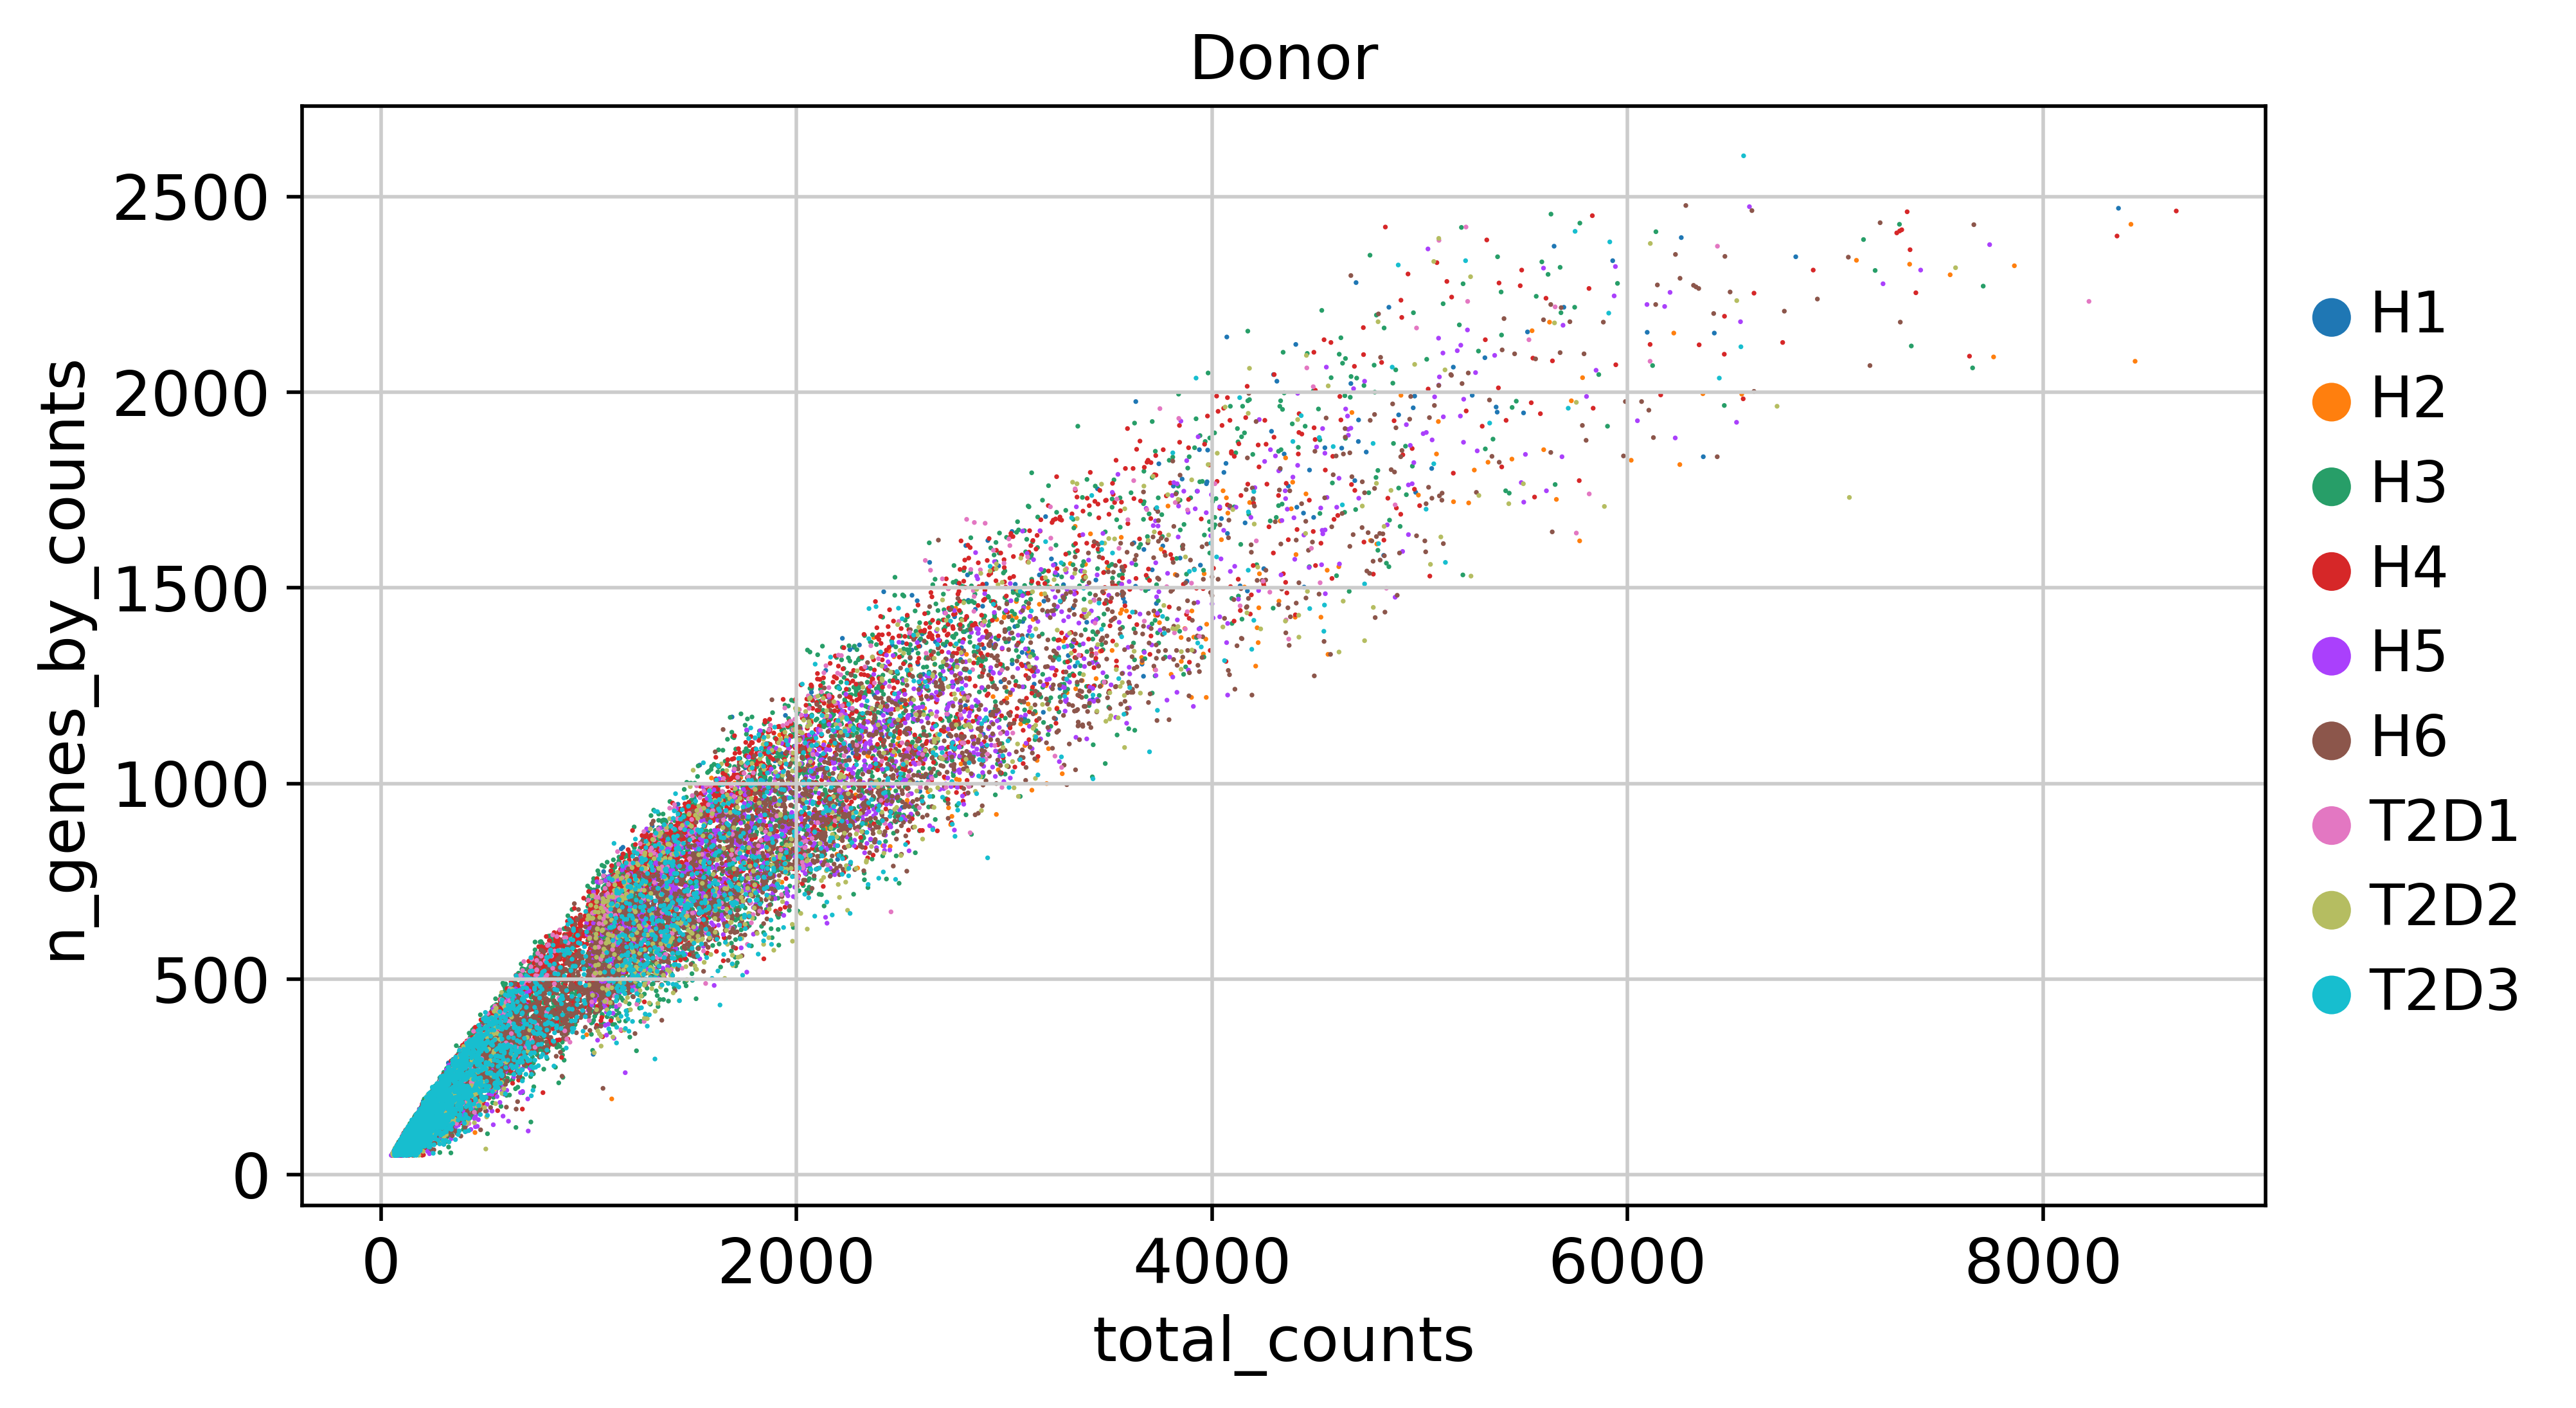

In [23]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color="Donor")

In [24]:
adata

AnnData object with n_obs × n_vars = 26226 × 13102
    obs: 'Donor', 'Celltype', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'Donor_colors'

In [25]:
adata = adata[adata.obs.pct_counts_mt<4, :].copy()
adata = adata[adata.obs.total_counts<6000, :].copy()
adata

AnnData object with n_obs × n_vars = 26105 × 13102
    obs: 'Donor', 'Celltype', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'Donor_colors'

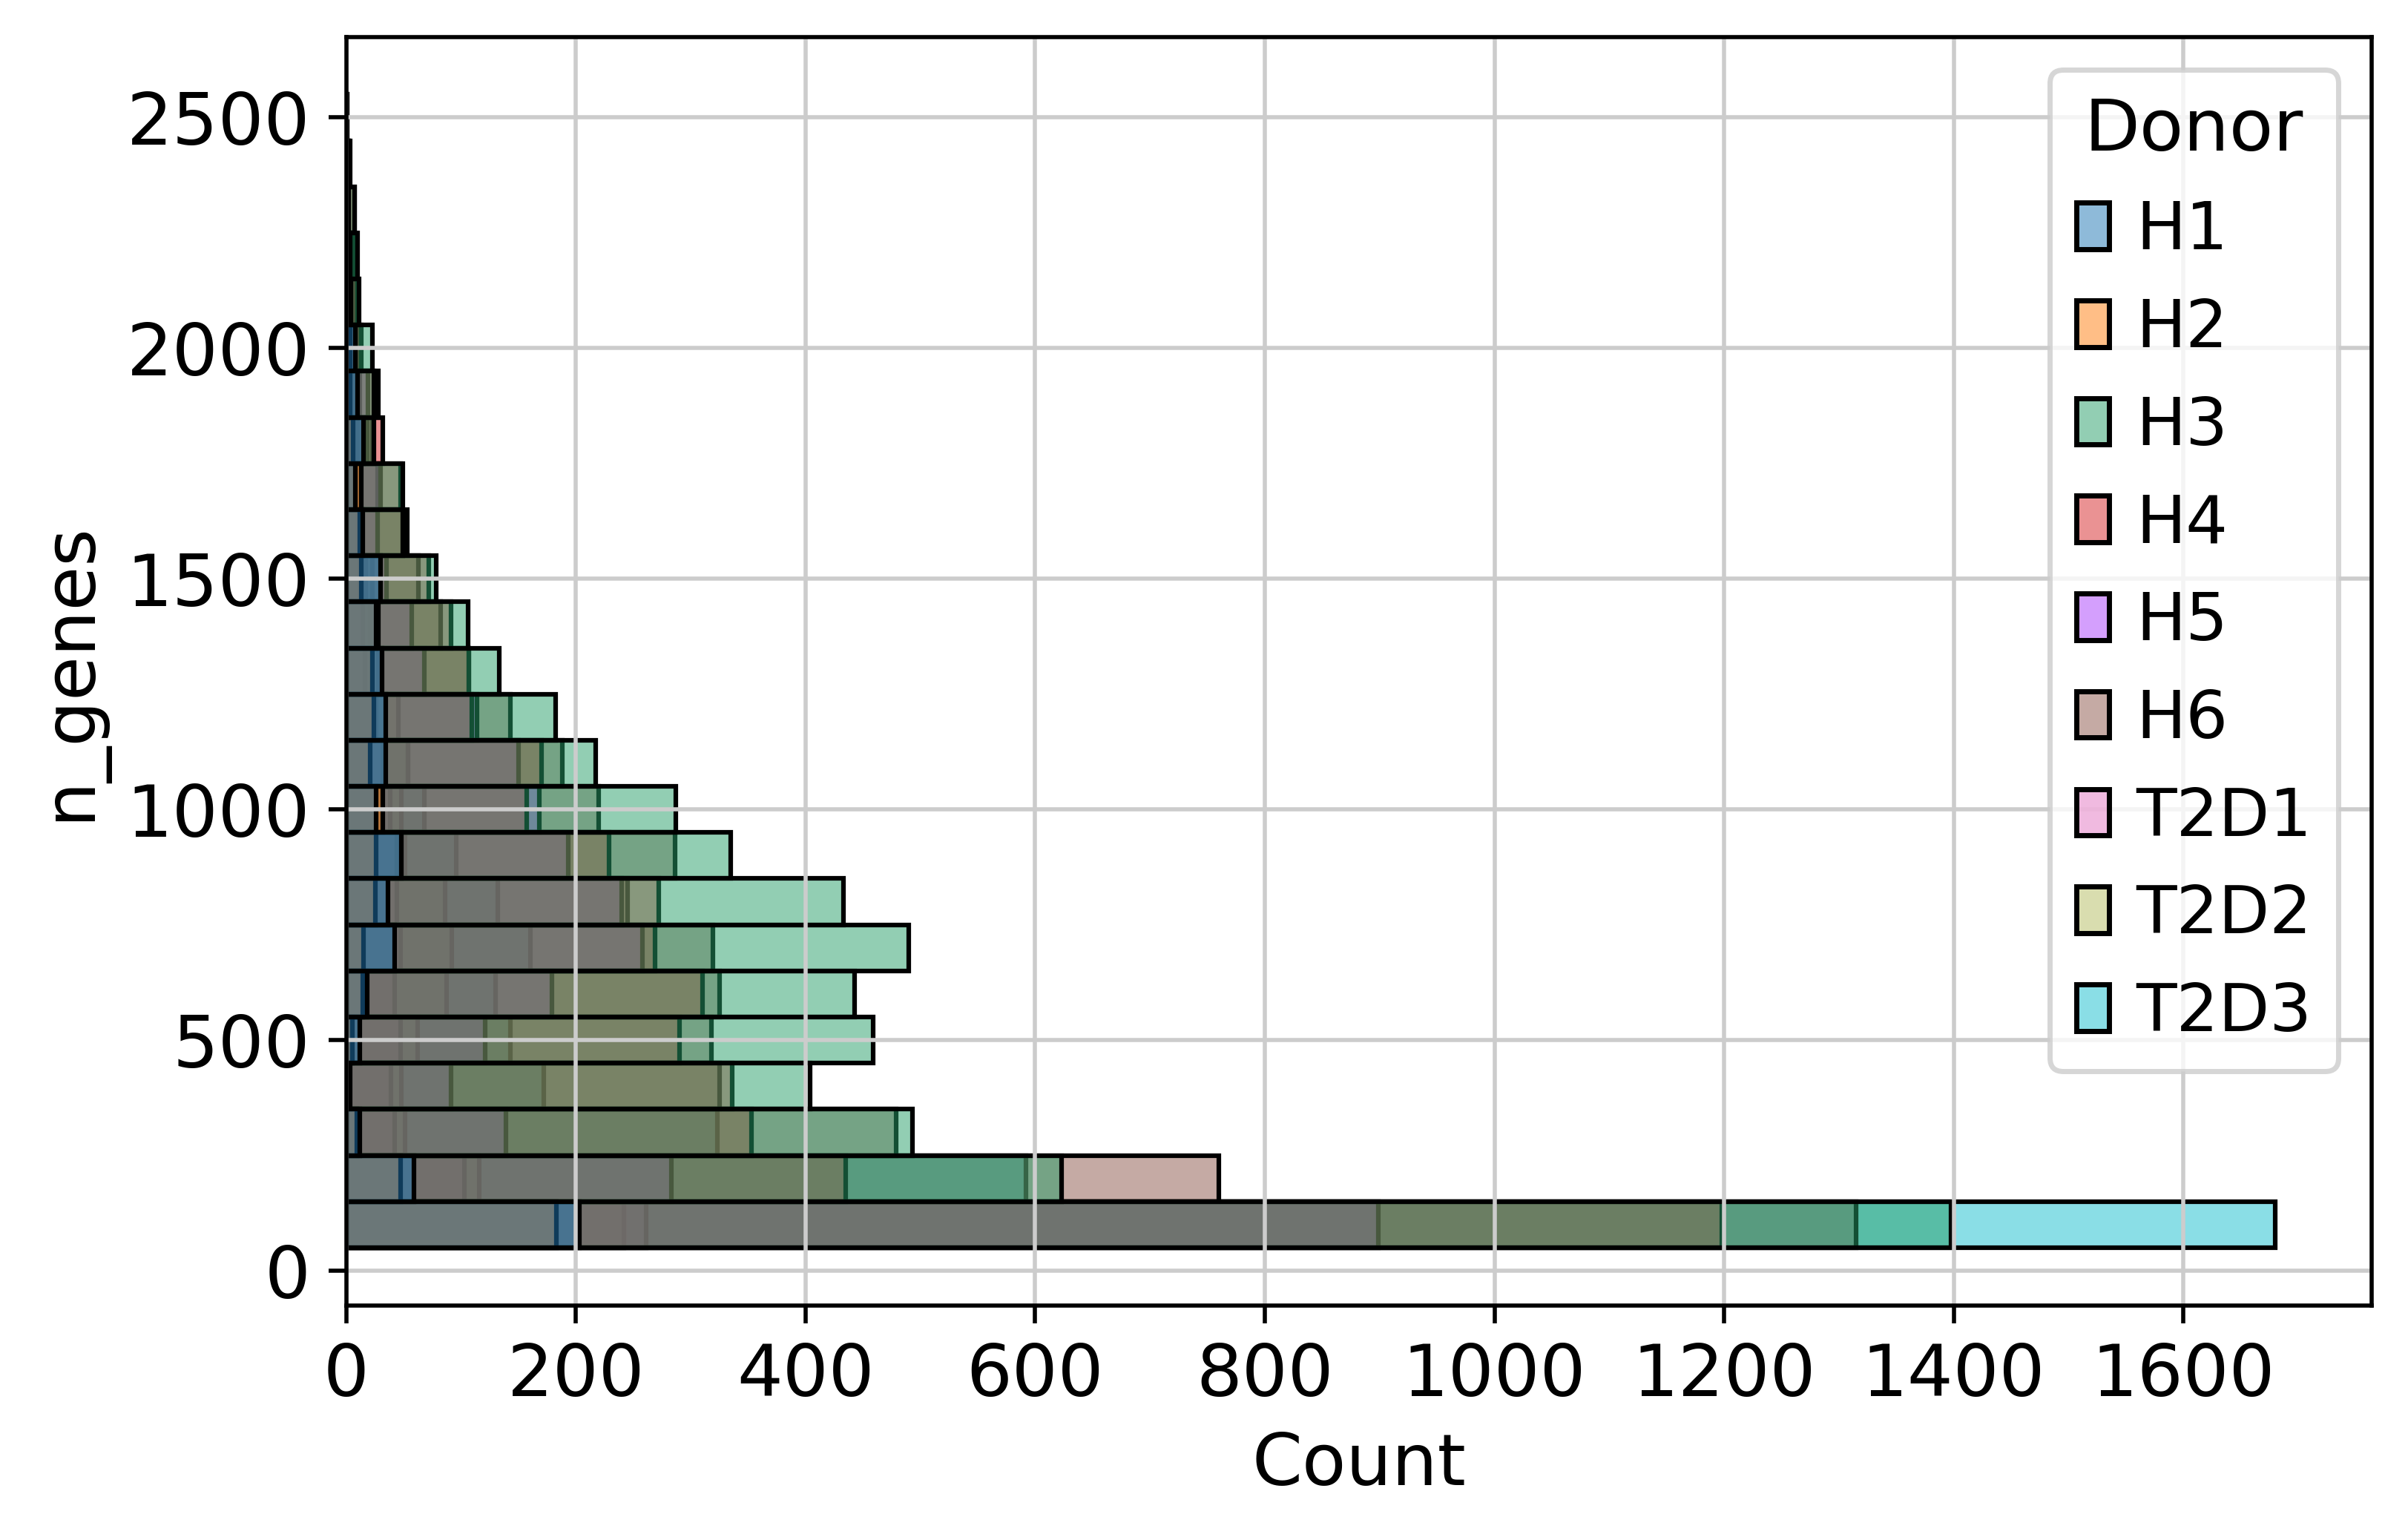

In [26]:
sns.histplot(y = "n_genes", hue="Donor", data=adata.obs.sort_values(by="Donor"), binwidth=100)

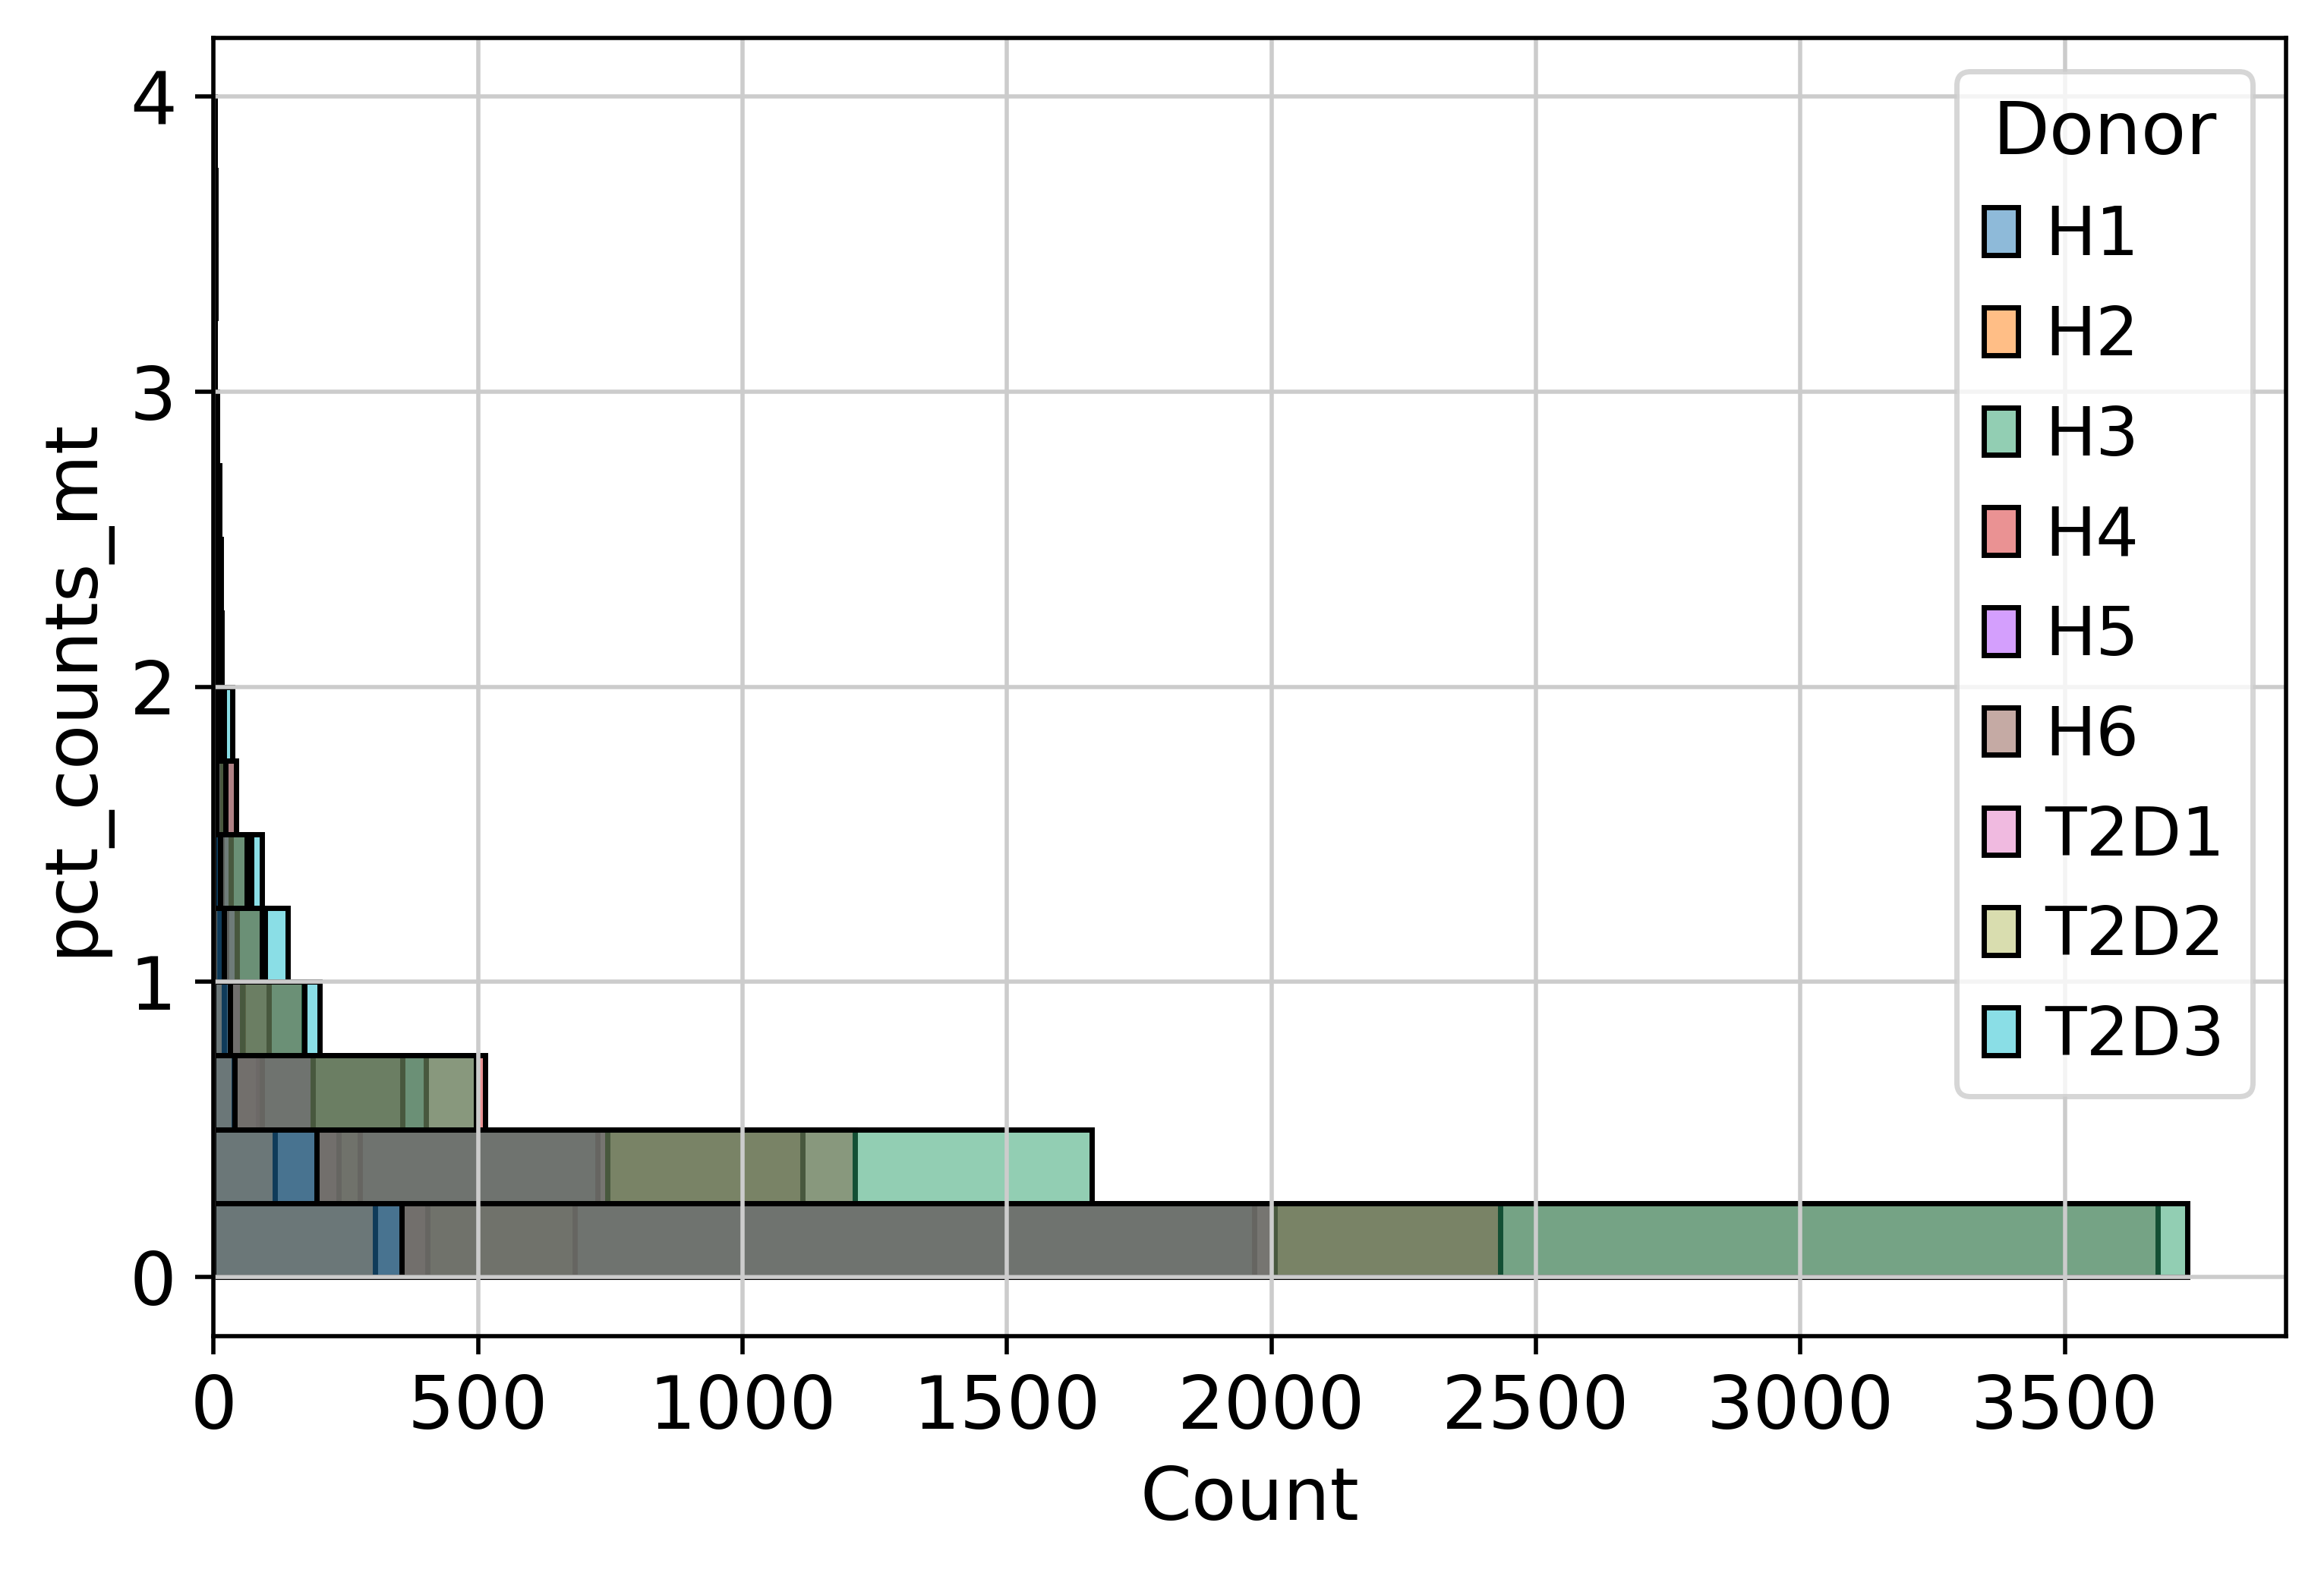

In [27]:
sns.histplot(y = "pct_counts_mt", hue="Donor", data=adata.obs.sort_values(by="Donor"), binwidth=0.25)

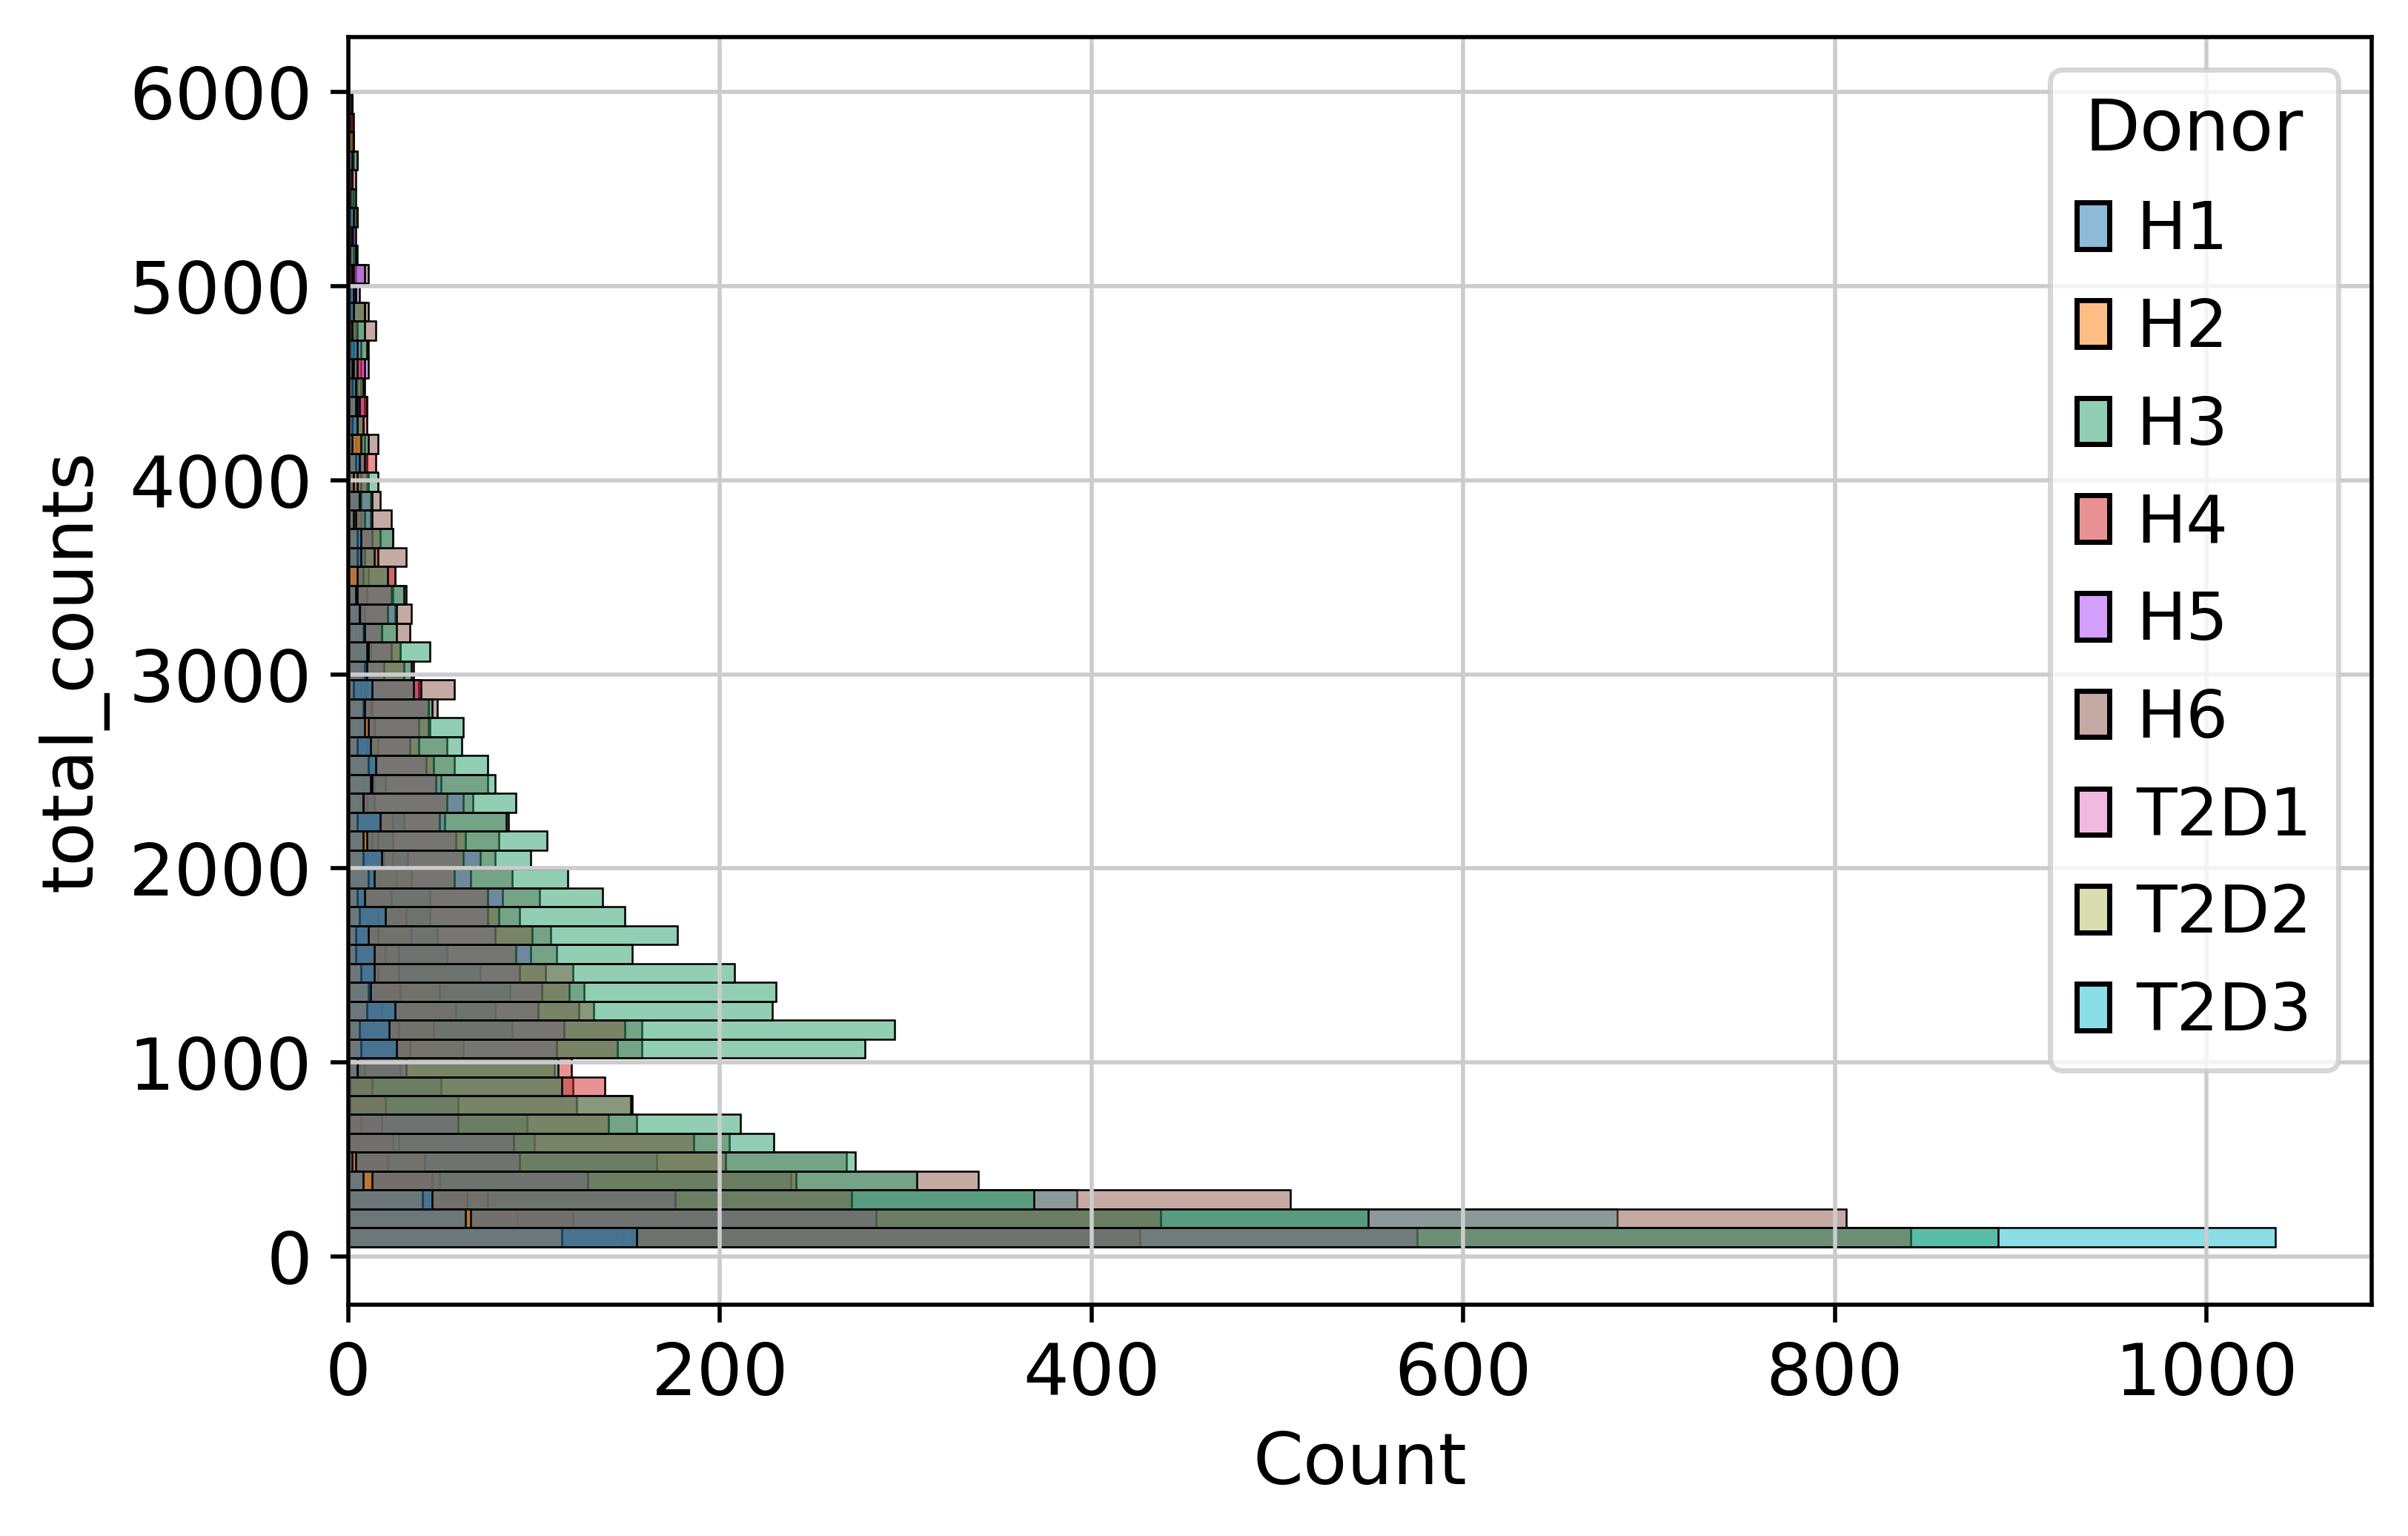

In [28]:
sns.histplot(y = "total_counts", hue="Donor", data=adata.obs.sort_values(by="Donor"))

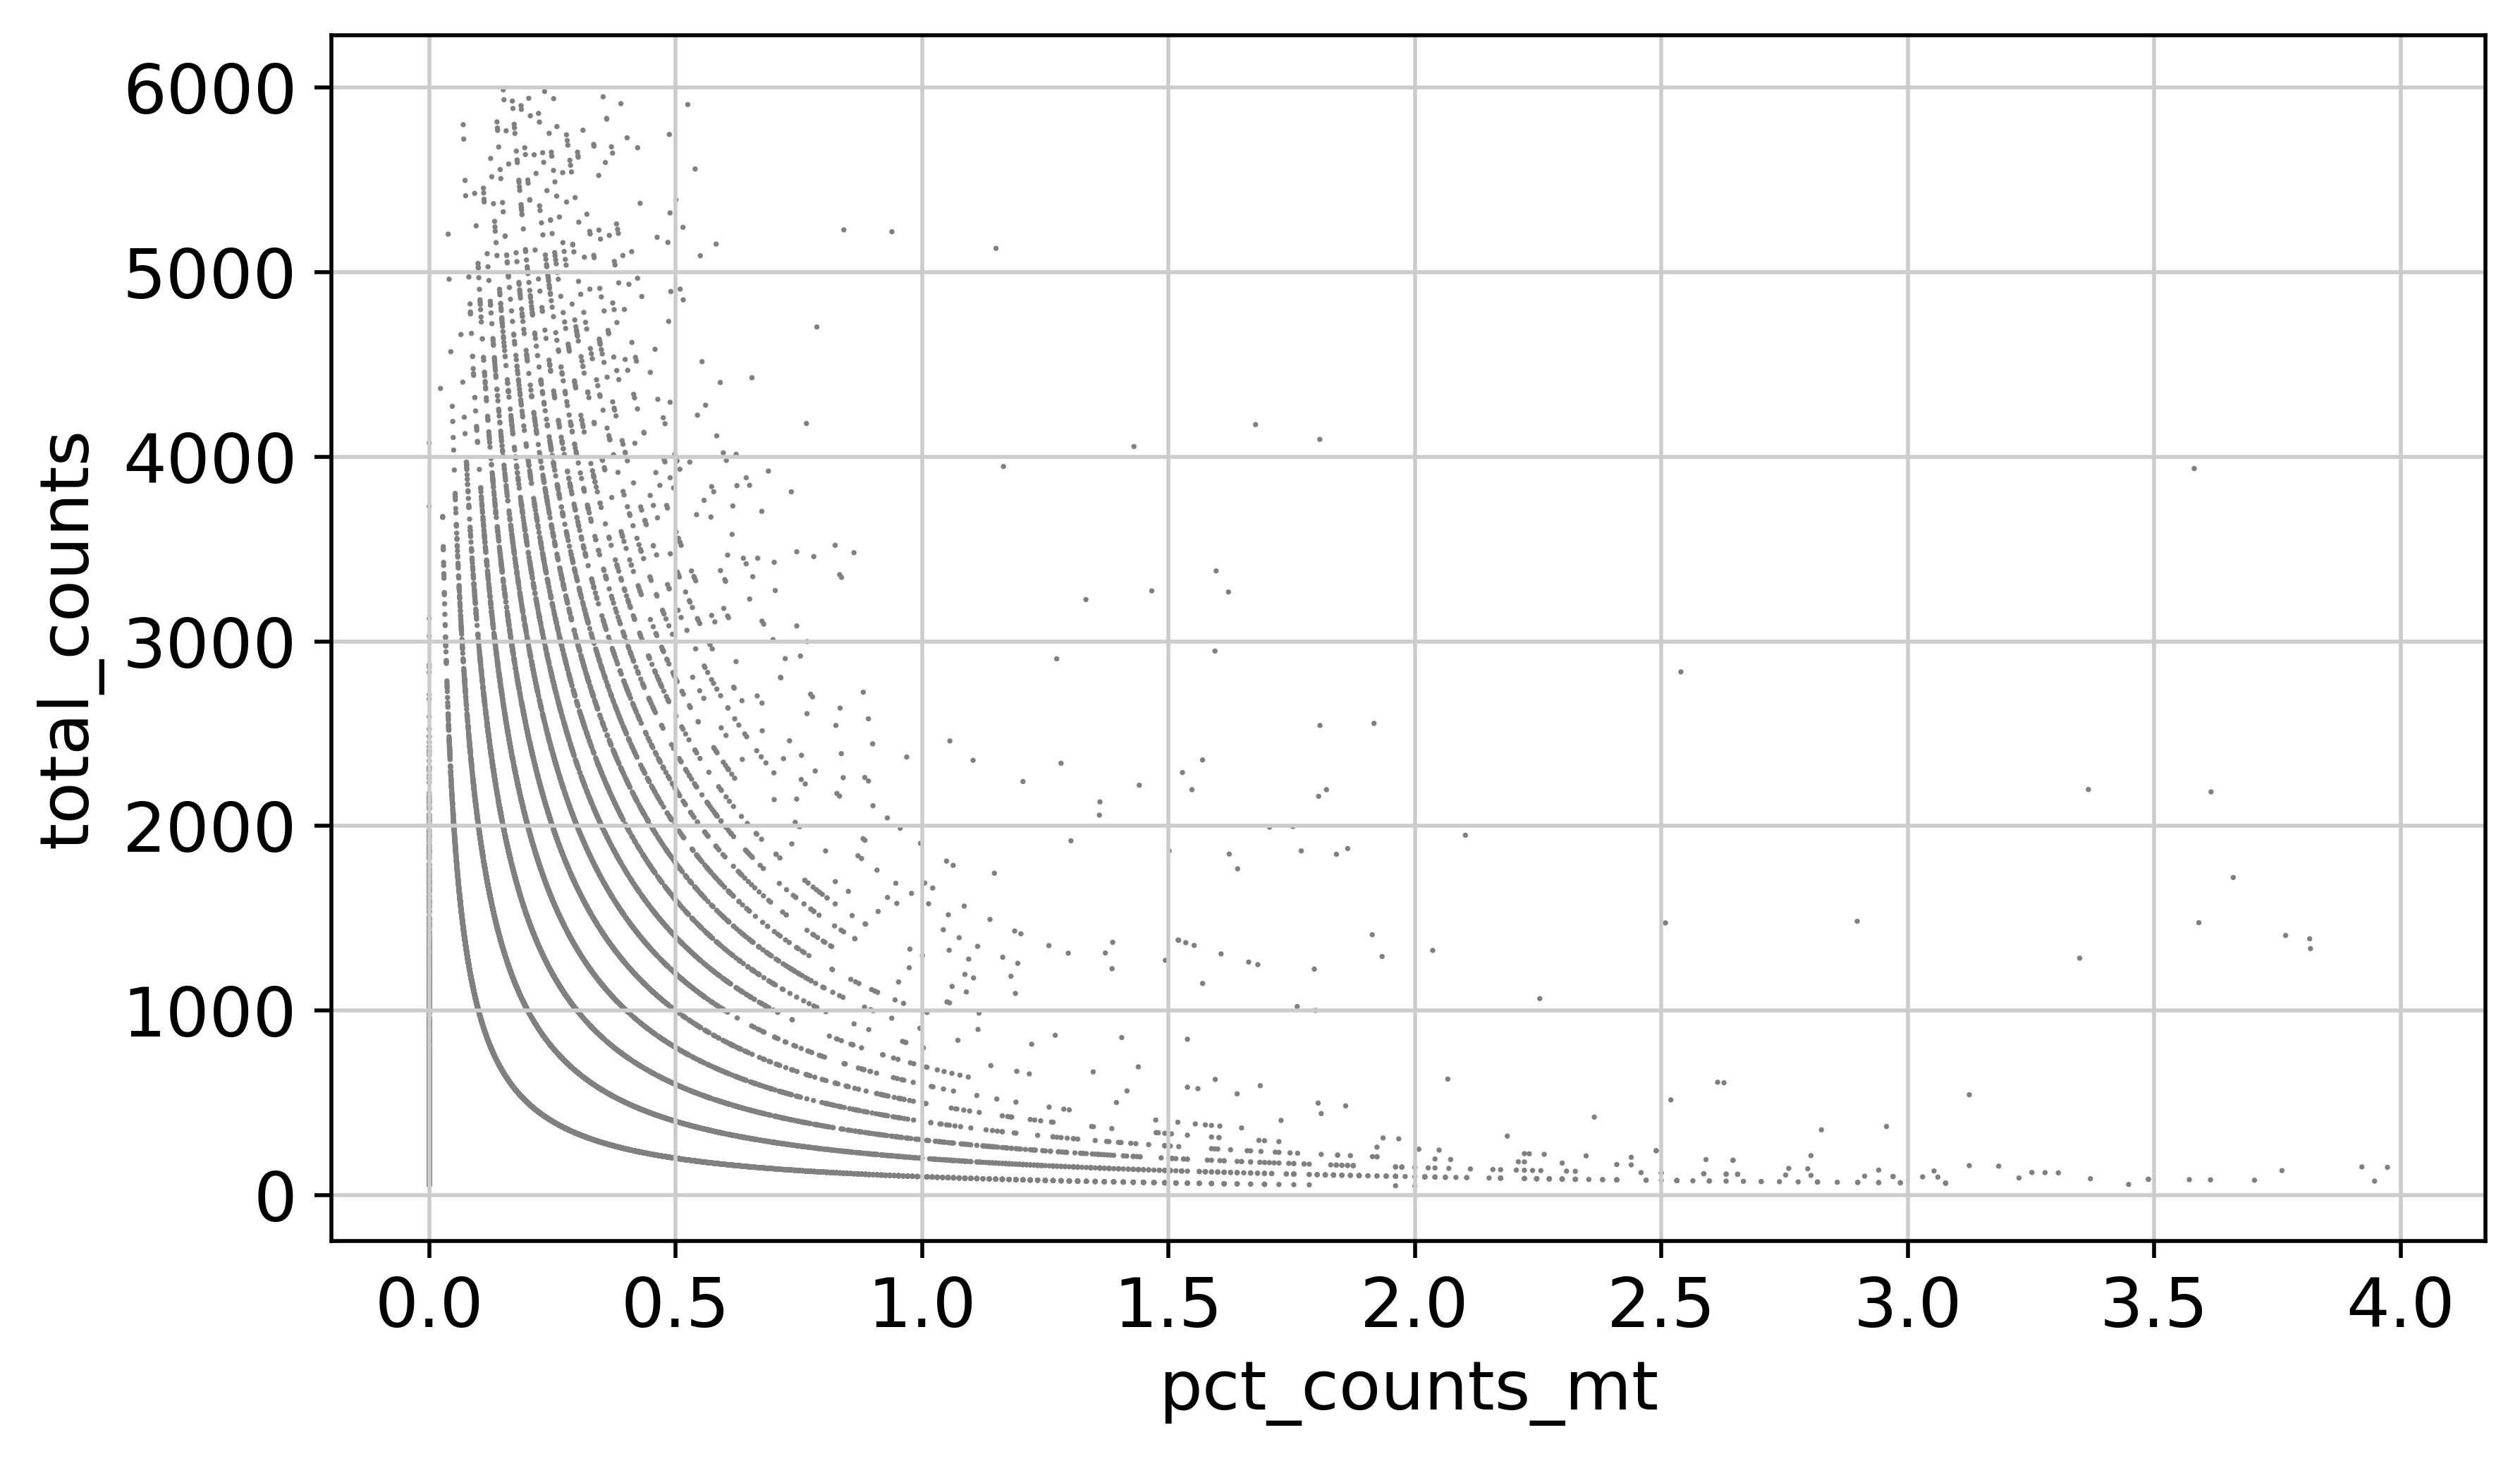

In [29]:
sc.pl.scatter(adata, x='pct_counts_mt', y='total_counts')

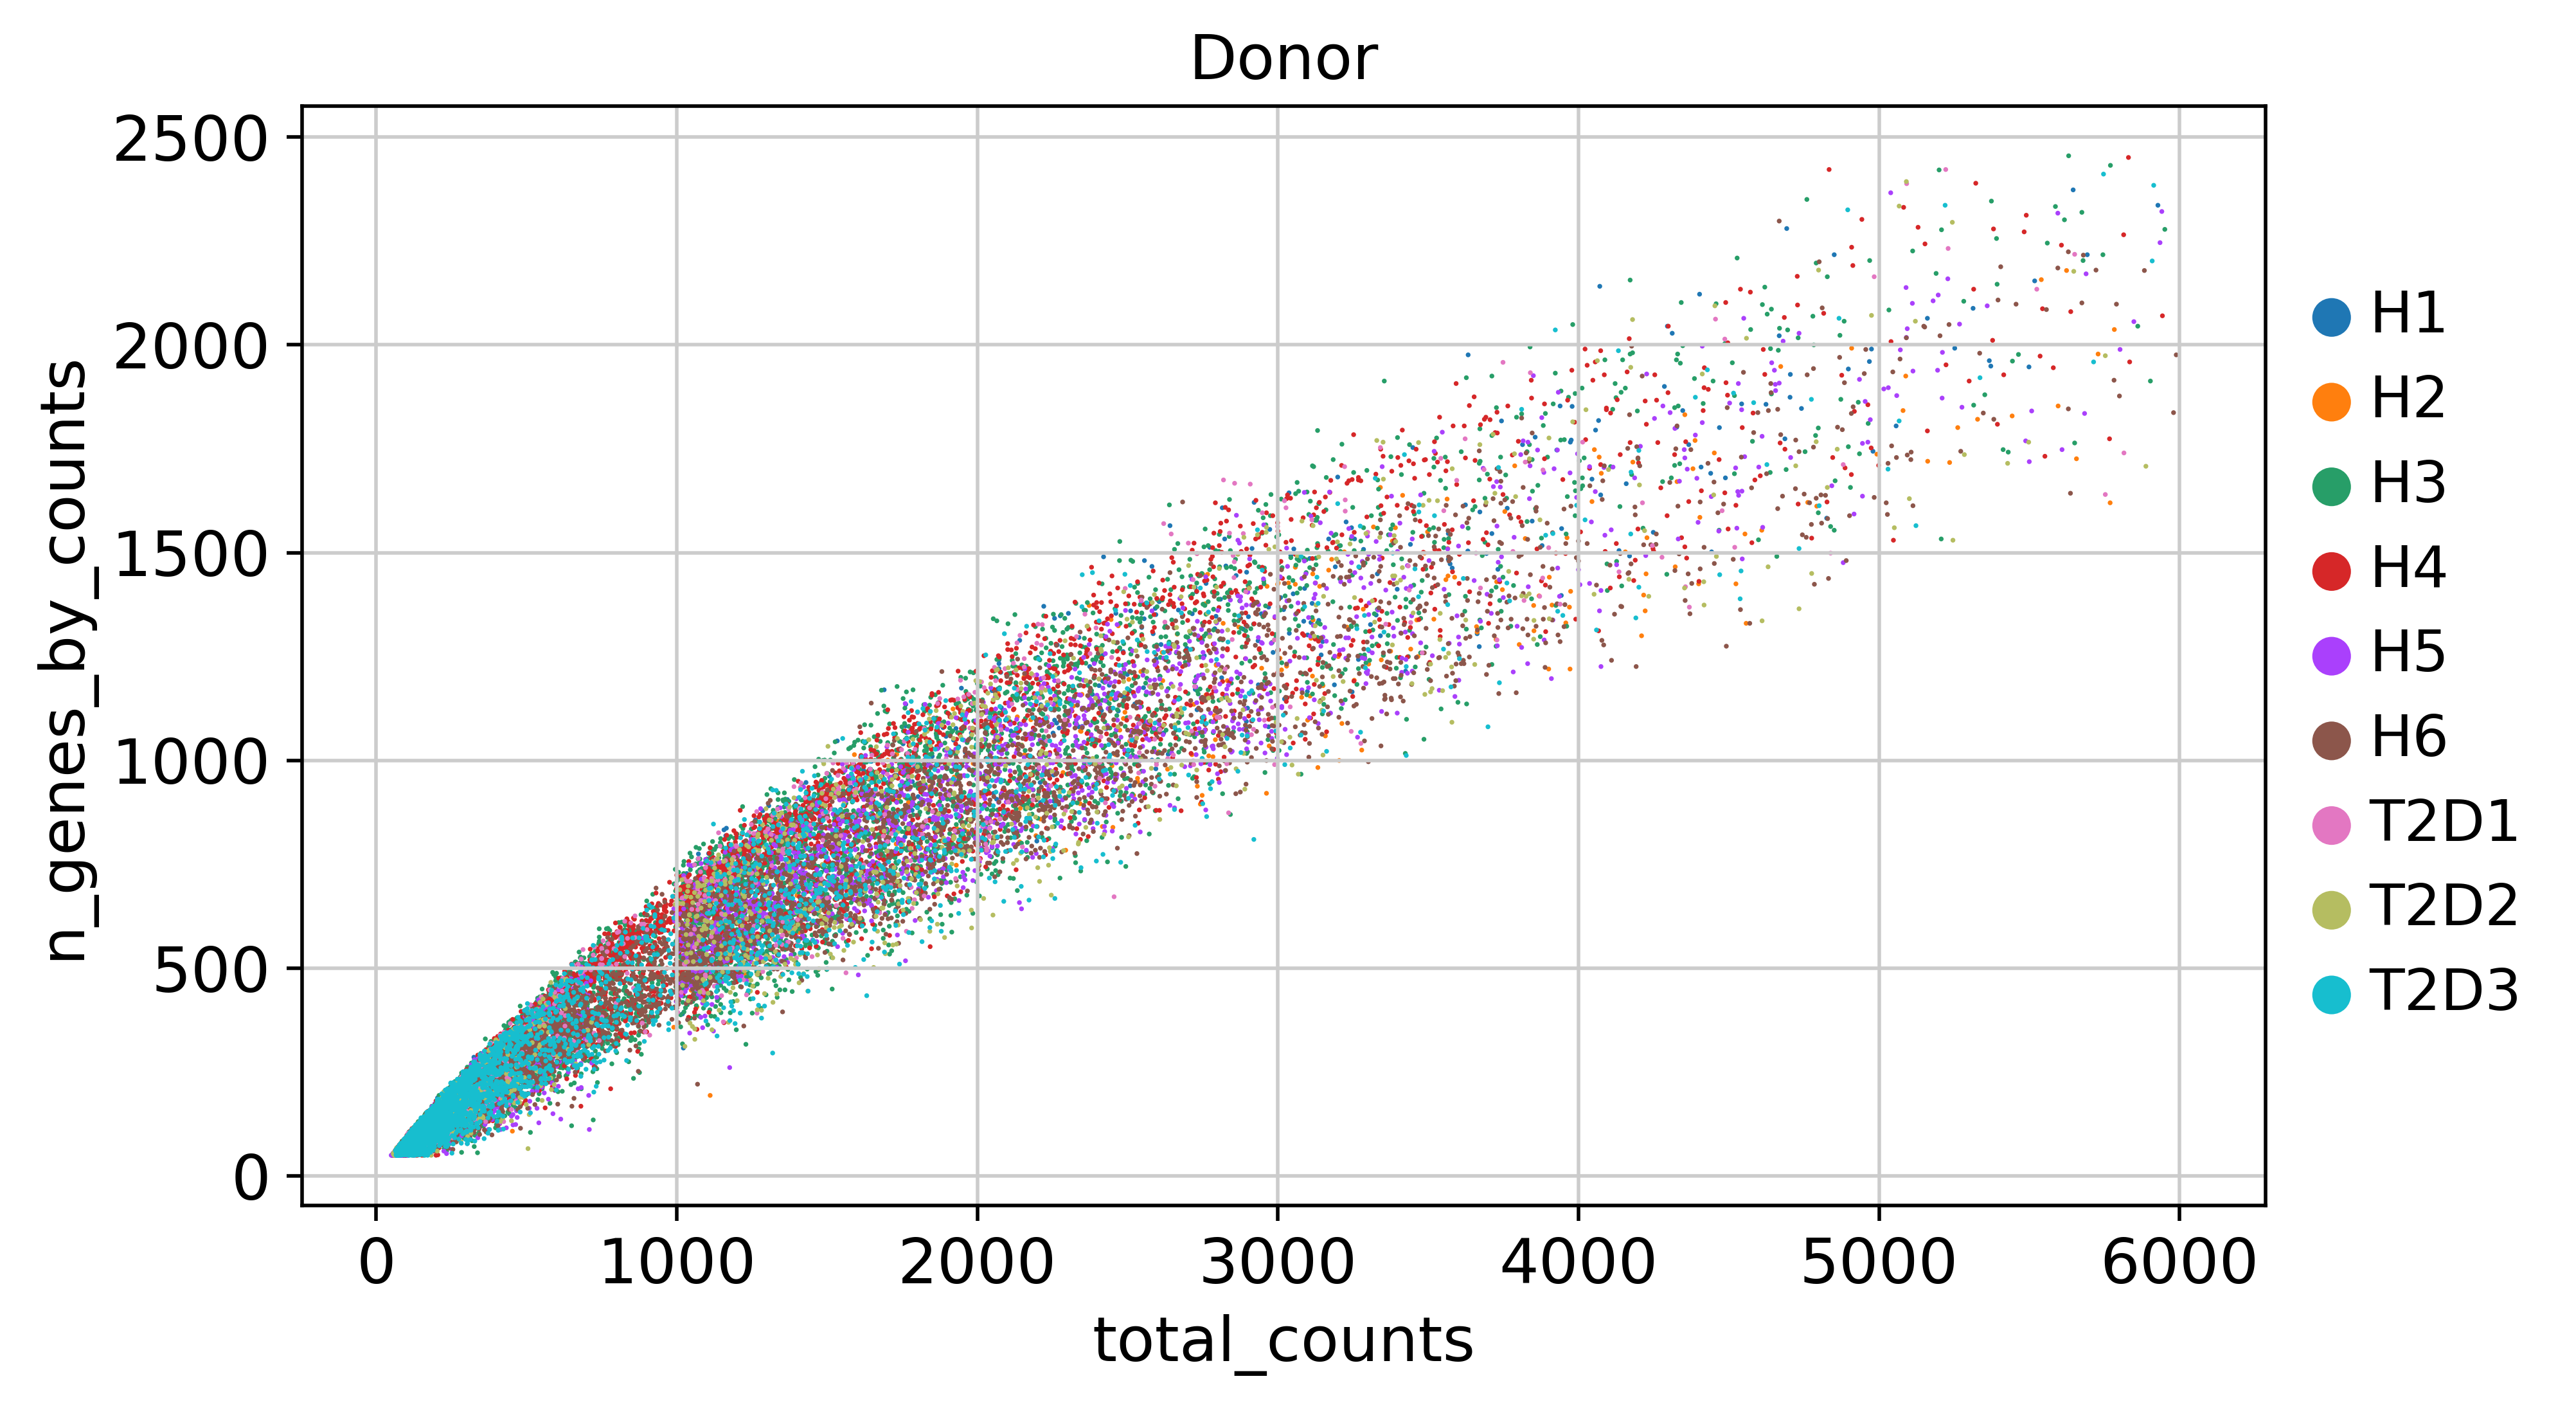

In [30]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color="Donor")

In [31]:
adata.obs.groupby("Donor").count()

Celltype  n_genes  ...  total_counts_mt  pct_counts_mt
Donor                     ...                                
H1          677      677  ...              677            677
H2          507      507  ...              507            507
H3         6282     6282  ...             6282           6282
H4         4596     4596  ...             4596           4596
H5         3112     3112  ...             3112           3112
H6         5311     5311  ...             5311           5311
T2D1        848      848  ...              848            848
T2D2       1111     1111  ...             1111           1111
T2D3       3661     3661  ...             3661           3661

[9 rows x 6 columns]

In [32]:
import numpy as np

In [33]:
cola = adata.obs.loc[:, ["Donor", "Celltype", "n_genes"]].groupby(["Donor", "Celltype"]).count()
x = pd.DataFrame(np.zeros((len(adata.obs.Donor.unique()), len(adata.obs.Celltype.unique()))), index=adata.obs.Donor.unique(), columns=adata.obs.Celltype.unique())
x

Alpha  Beta  delta   pp  duct  psc  Acinar  allBeta  Epsilon
H1      0.0   0.0    0.0  0.0   0.0  0.0     0.0      0.0      0.0
H2      0.0   0.0    0.0  0.0   0.0  0.0     0.0      0.0      0.0
H3      0.0   0.0    0.0  0.0   0.0  0.0     0.0      0.0      0.0
H4      0.0   0.0    0.0  0.0   0.0  0.0     0.0      0.0      0.0
H5      0.0   0.0    0.0  0.0   0.0  0.0     0.0      0.0      0.0
T2D1    0.0   0.0    0.0  0.0   0.0  0.0     0.0      0.0      0.0
T2D2    0.0   0.0    0.0  0.0   0.0  0.0     0.0      0.0      0.0
H6      0.0   0.0    0.0  0.0   0.0  0.0     0.0      0.0      0.0
T2D3    0.0   0.0    0.0  0.0   0.0  0.0     0.0      0.0      0.0

In [34]:
for i in x.index:
  for j in x.columns:
    if cola.loc[(i, j), "n_genes"] > 0:
      x.loc[i, j] = cola.loc[(i, j), "n_genes"]
x.index = x.index.astype(str)
x.sort_index(inplace=True, )
x

Alpha    Beta  delta     pp   duct    psc  Acinar  allBeta  Epsilon
H1     194.0   273.0   27.0   21.0   96.0   41.0    24.0      1.0      0.0
H2     217.0   204.0    9.0    4.0   33.0   34.0     6.0      0.0      0.0
H3    2855.0  2268.0  125.0  314.0  180.0  527.0     9.0      0.0      4.0
H4    1603.0  2297.0  125.0   99.0  422.0   45.0     3.0      0.0      2.0
H5    1551.0  1114.0   61.0   43.0  140.0  182.0    17.0      0.0      4.0
H6    3265.0  1651.0  139.0   81.0   57.0  110.0     8.0      0.0      0.0
T2D1   377.0   246.0   19.0   28.0  154.0   20.0     4.0      0.0      0.0
T2D2   556.0   359.0   34.0    7.0  105.0   45.0     5.0      0.0      0.0
T2D3  2110.0  1200.0   78.0   45.0   81.0  131.0    13.0      0.0      3.0

In [35]:
" ".join(x.sum().values.astype(int).astype(str))

'12728 9612 617 642 1268 1135 89 1 13'

In [36]:
" ".join(x.loc[x.index.isin(["H1", "H2", "H3", "H4", "H5", "H6"])].sum().values.astype(int).astype(str))

'9685 7807 486 562 928 939 67 1 10'

In [37]:
" ".join(x.loc[~x.index.isin(["H1", "H2", "H3", "H4", "H5", "H6"])].sum().values.astype(int).astype(str))

'3043 1805 131 80 340 196 22 0 3'

In [38]:
x.to_csv("./pancreas_ct1.csv")

In [40]:
adata = adata[~adata.obs.Celltype.isin(["allBeta", "Epsilon"])]
print(adata.obs.Celltype.unique())
adata

['Alpha', 'Beta', 'delta', 'pp', 'duct', 'psc', 'Acinar']
Categories (7, object): ['Alpha', 'Beta', 'delta', 'pp', 'duct', 'psc', 'Acinar']


View of AnnData object with n_obs × n_vars = 26091 × 13102
    obs: 'Donor', 'Celltype', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'Donor_colors'

In [41]:
cola = adata.obs.loc[:, ["Donor", "Celltype", "n_genes"]].groupby(["Donor", "Celltype"]).count()
x = pd.DataFrame(np.zeros((len(adata.obs.Donor.unique()), len(adata.obs.Celltype.unique()))), index=adata.obs.Donor.unique(), columns=adata.obs.Celltype.unique())
x

Alpha  Beta  delta   pp  duct  psc  Acinar
H1      0.0   0.0    0.0  0.0   0.0  0.0     0.0
H2      0.0   0.0    0.0  0.0   0.0  0.0     0.0
H3      0.0   0.0    0.0  0.0   0.0  0.0     0.0
H4      0.0   0.0    0.0  0.0   0.0  0.0     0.0
H5      0.0   0.0    0.0  0.0   0.0  0.0     0.0
T2D1    0.0   0.0    0.0  0.0   0.0  0.0     0.0
T2D2    0.0   0.0    0.0  0.0   0.0  0.0     0.0
H6      0.0   0.0    0.0  0.0   0.0  0.0     0.0
T2D3    0.0   0.0    0.0  0.0   0.0  0.0     0.0

In [42]:
for i in x.index:
  for j in x.columns:
    if cola.loc[(i, j), "n_genes"] > 0:
      x.loc[i, j] = cola.loc[(i, j), "n_genes"]
x.index = x.index.astype(str)
x.sort_index(inplace=True, )
x

Alpha    Beta  delta     pp   duct    psc  Acinar
H1     194.0   273.0   27.0   21.0   96.0   41.0    24.0
H2     217.0   204.0    9.0    4.0   33.0   34.0     6.0
H3    2855.0  2268.0  125.0  314.0  180.0  527.0     9.0
H4    1603.0  2297.0  125.0   99.0  422.0   45.0     3.0
H5    1551.0  1114.0   61.0   43.0  140.0  182.0    17.0
H6    3265.0  1651.0  139.0   81.0   57.0  110.0     8.0
T2D1   377.0   246.0   19.0   28.0  154.0   20.0     4.0
T2D2   556.0   359.0   34.0    7.0  105.0   45.0     5.0
T2D3  2110.0  1200.0   78.0   45.0   81.0  131.0    13.0

In [43]:
adata.raw = adata

In [44]:
gc.collect()

6791

In [45]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


extracting highly variable genes
    finished (0:00:08)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


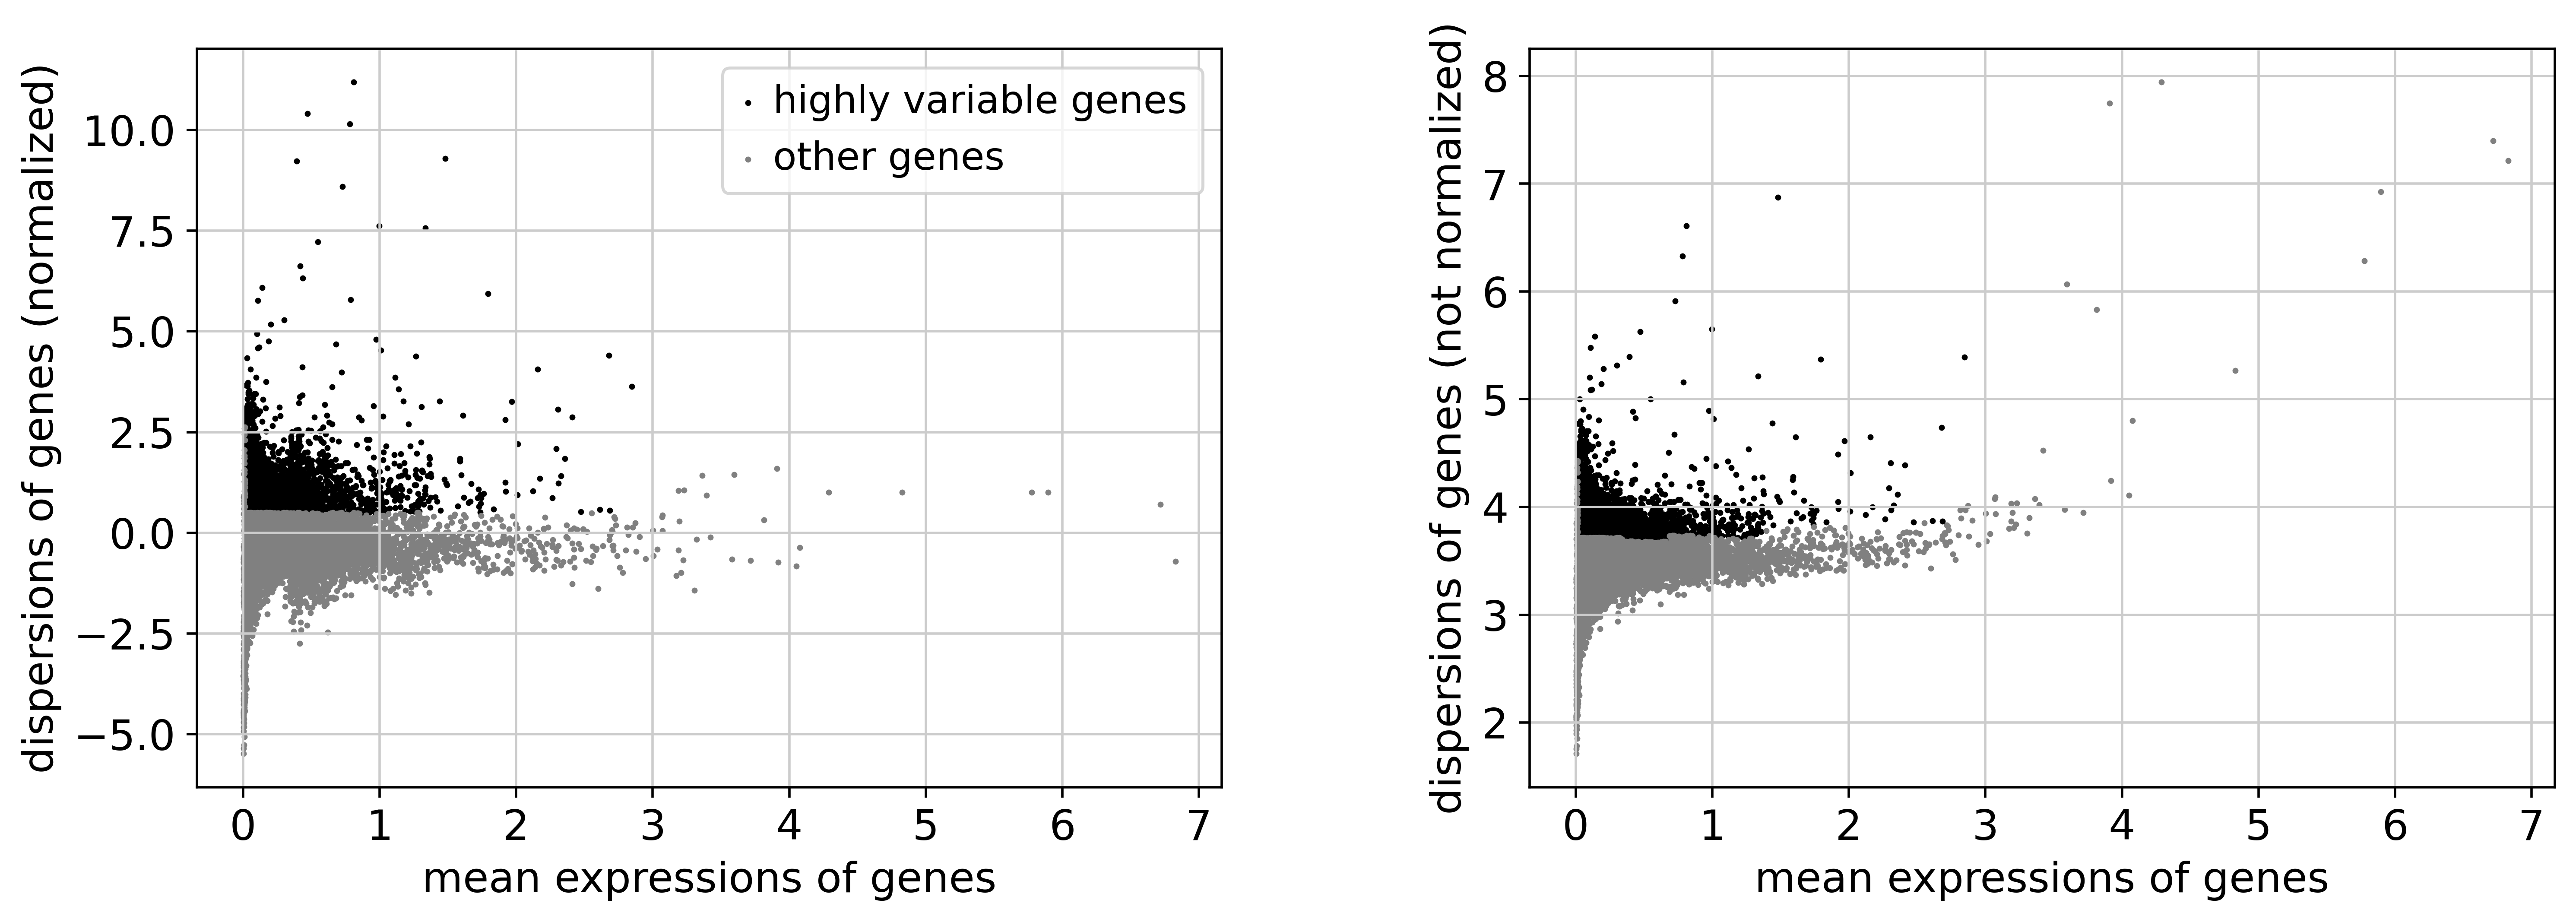

In [46]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [47]:

adata

AnnData object with n_obs × n_vars = 26091 × 13102
    obs: 'Donor', 'Celltype', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Donor_colors', 'log1p', 'hvg'

In [48]:
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts'])
sc.pp.scale(adata, max_value=10)

regressing out ['total_counts']


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


    finished (0:02:18)


In [49]:
adata

AnnData object with n_obs × n_vars = 26091 × 3447
    obs: 'Donor', 'Celltype', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Donor_colors', 'log1p', 'hvg'

In [50]:
gc.collect()

5642

### PCA

In [51]:
sc.tl.pca(adata, svd_solver='arpack', use_highly_variable=True)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:41)


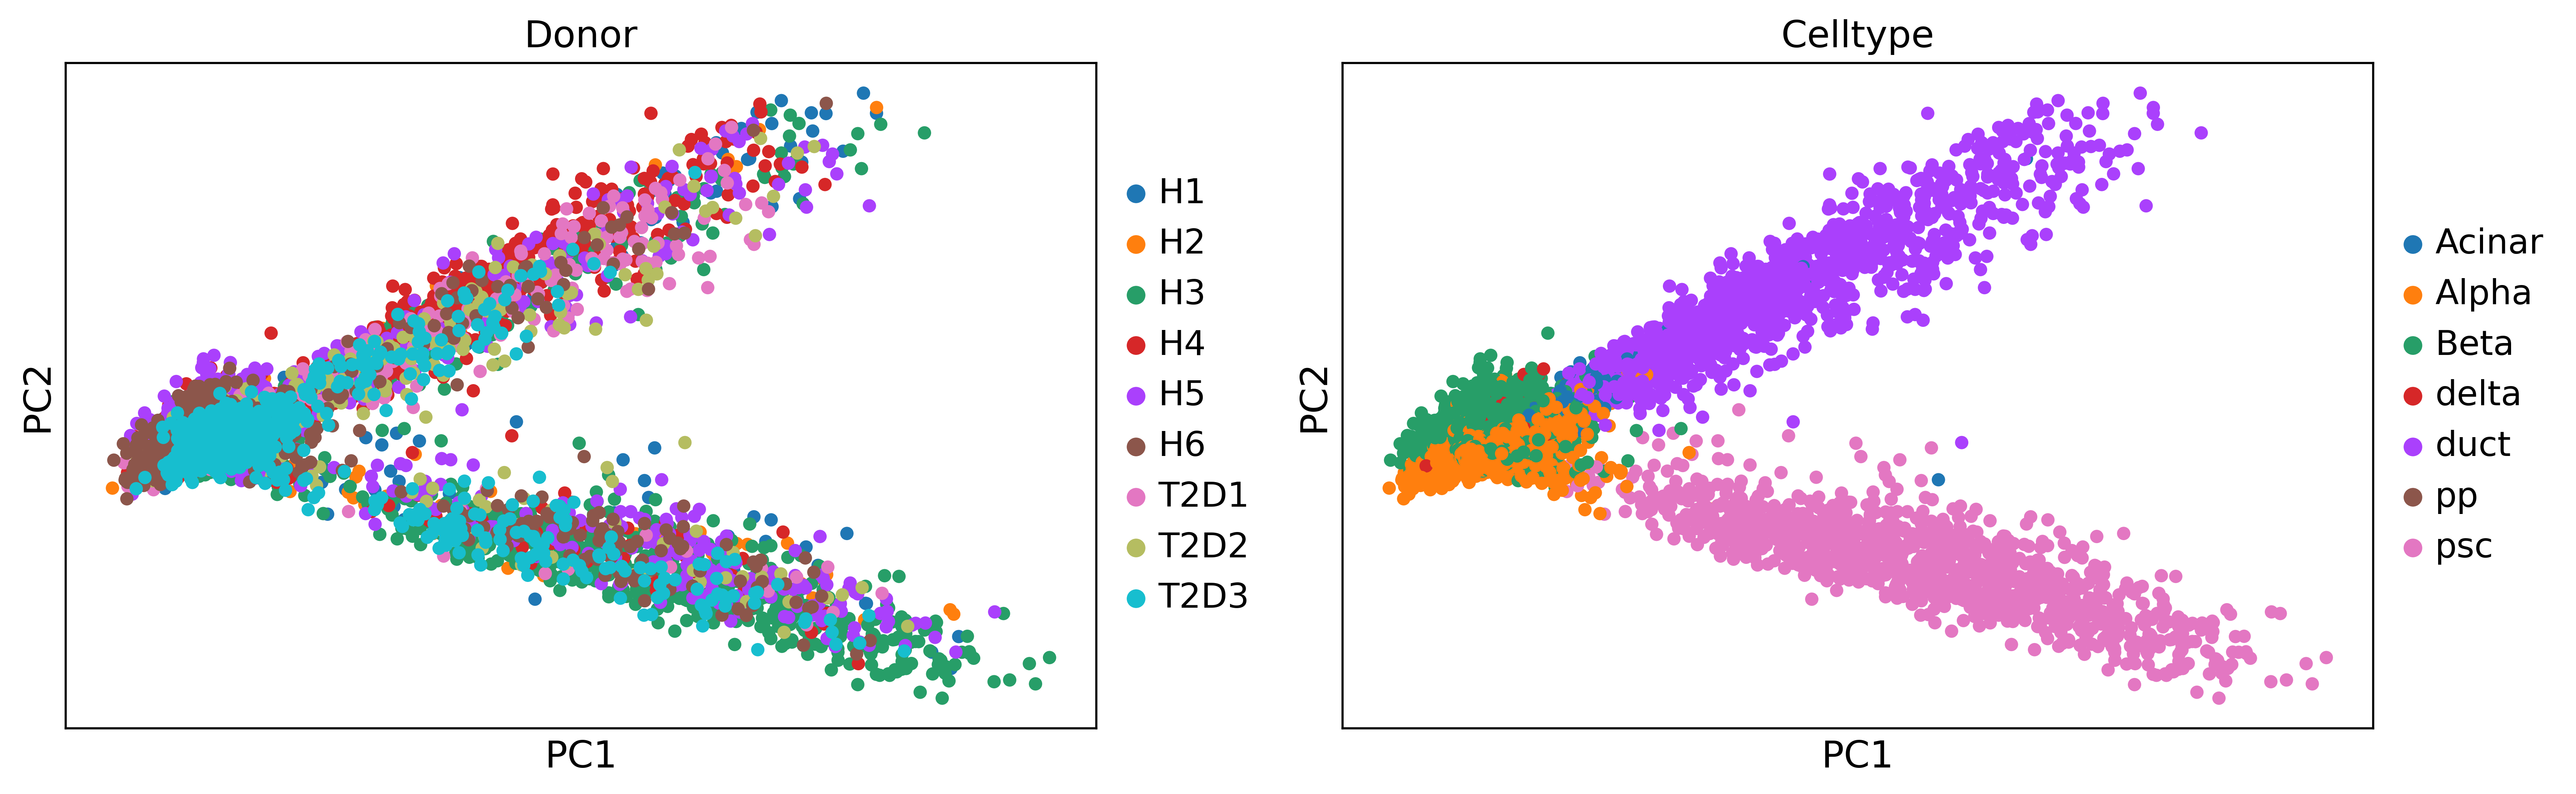

In [52]:
sc.pl.pca(adata, color=["Donor", "Celltype"], size=100, ncols=2)

In [53]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=40)
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 40


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:31)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:46)


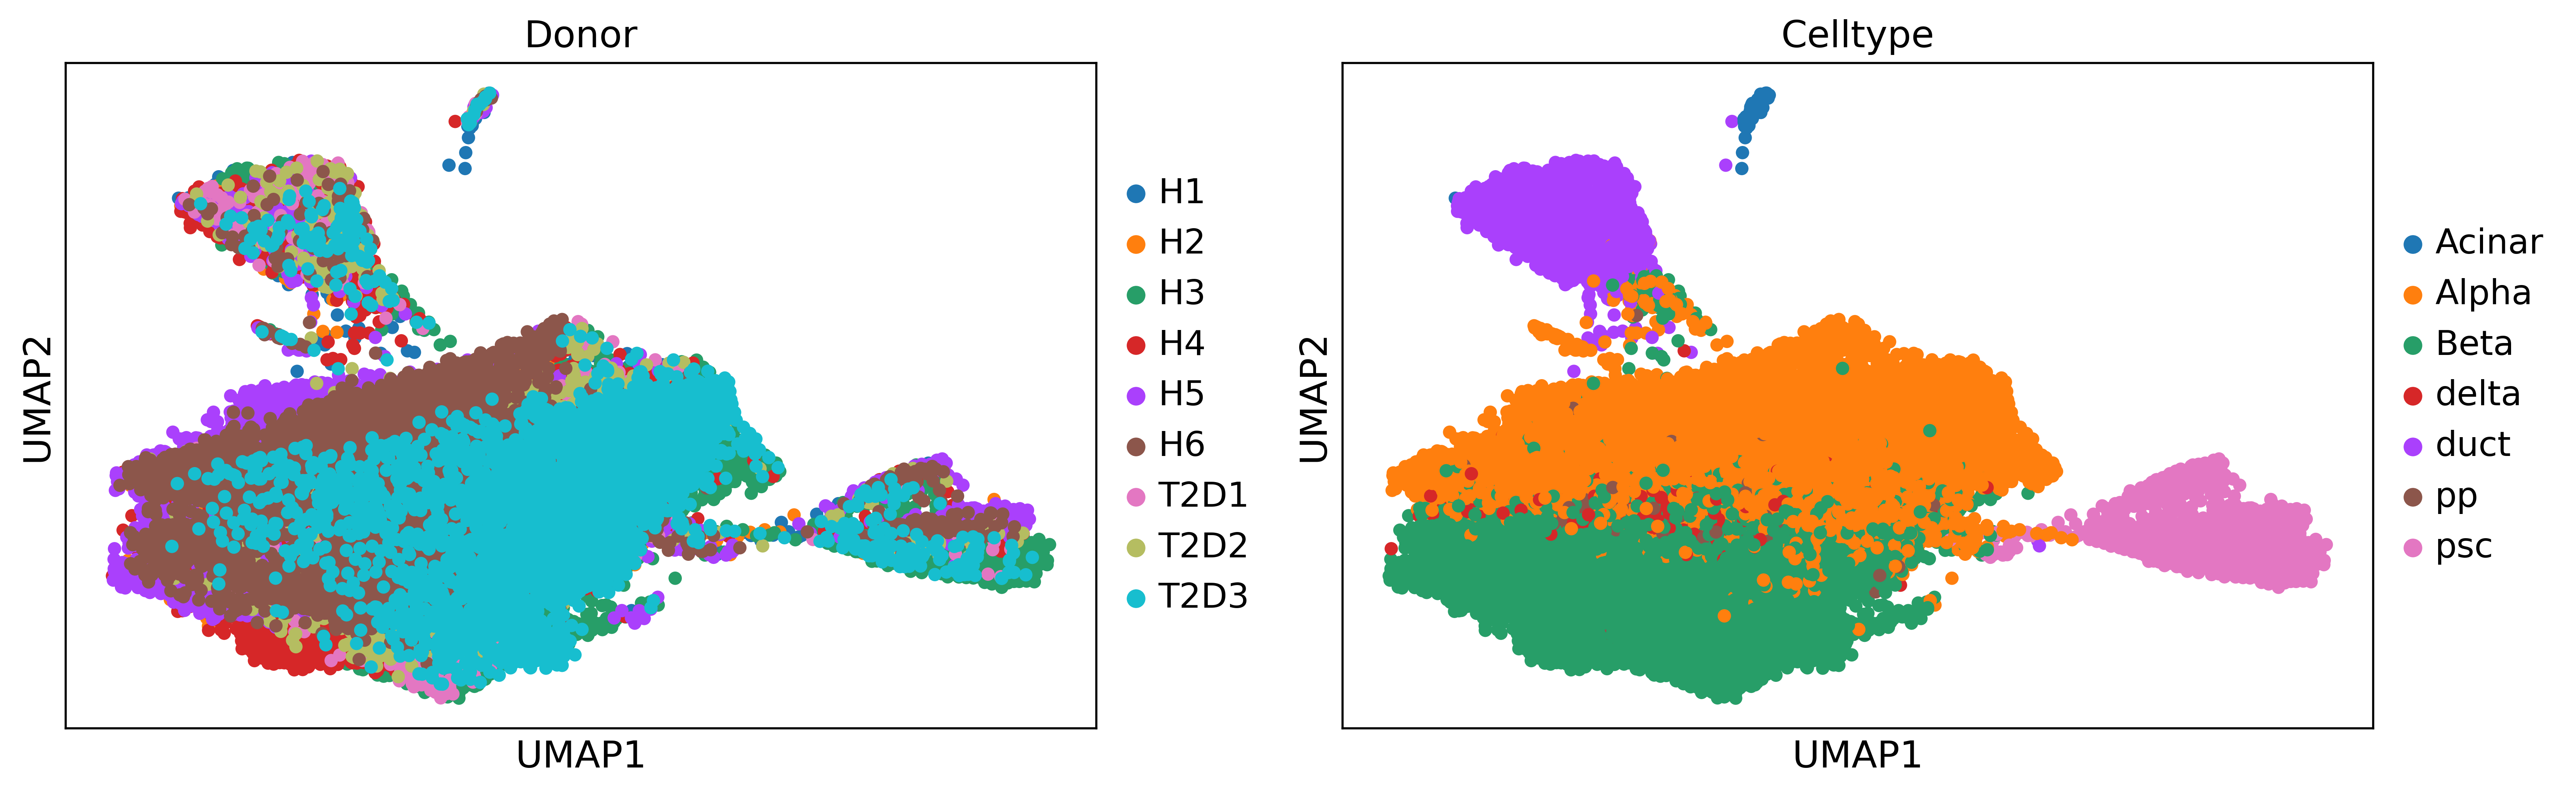

In [54]:
sc.pl.umap(adata, color=["Donor", "Celltype"], ncols=2, size=100, use_raw=True)

### Salvar

In [55]:
adata.write("./pancreas.h5ad")